In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
import pickle

# for GLoVe
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# for Doc2Vec
import nltk
nltk.download('punkt_tab')

# for Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\calla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [49]:
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import torch

# Import and process the dataset

## Import the dataset

In [50]:
news = pd.read_csv("News.csv")
news

Unnamed: 0                                              title  \
0               0   Donald Trump Sends Out Embarrassing New Year’...   
1               1   Drunk Bragging Trump Staffer Started Russian ...   
2               2   Sheriff David Clarke Becomes An Internet Joke...   
3               3   Trump Is So Obsessed He Even Has Obama’s Name...   
4               4   Pope Francis Just Called Out Donald Trump Dur...   
...           ...                                                ...   
44914       21412  'Fully committed' NATO backs new U.S. approach...   
44915       21413  LexisNexis withdrew two products from Chinese ...   
44916       21414  Minsk cultural hub becomes haven from authorities   
44917       21415  Vatican upbeat on possibility of Pope Francis ...   
44918       21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
44914  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44915  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44916  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44917  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44918  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                    date  class  
0      December 31, 2017      0  
1      December 31, 2017      0  
2      December 30, 2017      0  
3      December 29, 2017      0  
4      December 25, 2017      0  
...                  ...    ...  
44914   August 22, 2017       1  
44915   August 22, 2017       1  
44916   August 22, 2017       1  
44917   August 22, 2017       1  
44918   August 22, 2017       1  

[44919 rows x 6 columns]

<Axes: xlabel='class'>

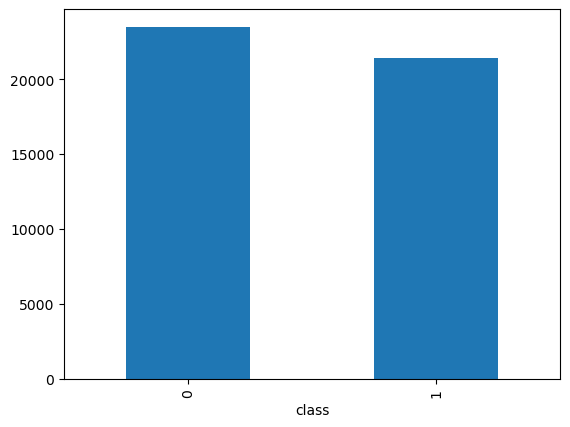

In [51]:
news["class"].value_counts().plot(kind="bar")

## Drop irrelavent columns and shuffle the dataset

In [52]:
news = pd.read_csv("News.csv")
for col in ["Unnamed: 0", "subject", "date", "title"]:
    if col in news.columns: news = news.drop([col], axis=1)

news = news.drop_duplicates()
news = news.sample(frac=1)
news

text  class
40690  MEXICO CITY (Reuters) - Mexican state oil comp...      1
14849  CAN WE JUST STOP ALLOWING Muslim Refugees and ...      0
2703   Donald Trump is either really desperate to mak...      0
7772   A Trio of Neo-Nazi, Confederate flag-waving wh...      0
30551  WASHINGTON (Reuters) - U.S. Vice President-ele...      1
...                                                  ...    ...
27133  WASHINGTON (Reuters) - The U.S. Senate voted o...      1
8954   For years now, sane-minded individuals in Cong...      0
34890  LIMA (Reuters) - The Fujimori clan is at it ag...      1
24858  BEIJING (Reuters) - China said on Monday it ho...      1
35485  SANTIAGO (Reuters) - Billionaire conservative ...      1

[38658 rows x 2 columns]

In [53]:
testing_ratio = 0.1
testing_set = news[:int(len(news)*testing_ratio)]
dataset = news.iloc[int(len(news)*testing_ratio):]

In [54]:
testing_set

text  class
40690  MEXICO CITY (Reuters) - Mexican state oil comp...      1
14849  CAN WE JUST STOP ALLOWING Muslim Refugees and ...      0
2703   Donald Trump is either really desperate to mak...      0
7772   A Trio of Neo-Nazi, Confederate flag-waving wh...      0
30551  WASHINGTON (Reuters) - U.S. Vice President-ele...      1
...                                                  ...    ...
16233  President Trump s rally in FL on Saturday was ...      0
10814  It looks like Bill O Reilly is getting the las...      0
29916  WASHINGTON (Reuters) - Classified documents th...      1
33666  NEW YORK (Reuters) - Donald Trump’s presidenti...      1
38173  BEIJING (Reuters) - Chinese Foreign Minister W...      1

[3865 rows x 2 columns]

In [55]:
dataset

text  class
8041   Coming off from her latest record-breaking alb...      0
24706  WASHINGTON (Reuters) - U.S. Senate Republicans...      1
44635  NAIROBI (Reuters) - Kenyan President Uhuru Ken...      1
5747   Donald Trump had a prime opportunity to take a...      0
14217  After watching this telling video, you ll wond...      0
...                                                  ...    ...
27133  WASHINGTON (Reuters) - The U.S. Senate voted o...      1
8954   For years now, sane-minded individuals in Cong...      0
34890  LIMA (Reuters) - The Fujimori clan is at it ag...      1
24858  BEIJING (Reuters) - China said on Monday it ho...      1
35485  SANTIAGO (Reuters) - Billionaire conservative ...      1

[34793 rows x 2 columns]

# Help functions

In [56]:
def printMetrics(y, y_pred, method):
    print("Accuracy:")
    print(accuracy_score(y, y_pred))
    print("\n")

    print(f"Classification Report: {method}")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    tn, fp, fn, tp = cm.flatten()
    results = {'Metric': ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)'], 'Count': [tp, tn, fp, fn]}
    results = pd.DataFrame(results)
    return results

In [57]:
def train(X, y, method, test_size=0.25, max_iter=10000, show_metric = True):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    if method == "Logistic":
        model = LogisticRegression(max_iter=max_iter)
    elif method == "Decision_Tree":
        model = DecisionTreeClassifier()
    elif method == "MLP":
        model = MLPClassifier(max_iter=max_iter)
    else:
        print(f"unknown method: {method}")
        return None

    try:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        if show_metric: printMetrics(y_test, y_pred, method)
        return model
    except Exception as e:
        print(f"An error occurred during model training: {e}")
        return None

# Word Embedding

## `word2vec` model by continous bag of words

### Tokenization

In [58]:
from tqdm import tqdm
import re

In [59]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda x: remove_stopwords(x))

def preprocess_text(text_data, show_bar = True):
     preprocessed_text = []
     for passage in tqdm(text_data) if show_bar else text_data:
          passage = re.sub(r'\b(?:https?://|www\.)\S+\b', '', passage)

          passage = re.sub("[^a-zA-Z]", " ", passage)
          
          # Split into tokens based on whitespace
          tokens = passage.split()

          # Filter out empty tokens and unwanted ones
          tokens = [token for token in tokens if len(token) > 1]
          preprocessed_text.append(tokens)

     return preprocessed_text

C:\Users\calla\AppData\Local\Temp\ipykernel_23948\4006837793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: remove_stopwords(x))


In [60]:
preprocessed_text = preprocess_text(dataset['text'].values) ##remember to remove .iloc[]
len(preprocessed_text)

  0%|          | 0/34793 [00:00<?, ?it/s]

100%|██████████| 34793/34793 [00:03<00:00, 9608.55it/s]


34793

### By Continous Bag of Words

In [61]:
num_row =  dataset.shape[0]
vector_dim = 100

In [62]:
from gensim.models.word2vec import Word2Vec

In [63]:
model = Word2Vec(sentences=preprocessed_text, vector_size=vector_dim, window=10, min_count=1, workers=4, sg=0)  #sg= 1 means using Skip-Gram,

In [64]:
sims = model.wv.most_similar('Trump', topn=20)  # get other similar words
sims

[('elect', 0.5585623979568481),
 ('Conway', 0.516728401184082),
 ('him', 0.514259397983551),
 ('himself', 0.5030456781387329),
 ('actually', 0.4894106686115265),
 ('He', 0.48249390721321106),
 ('Romney', 0.47461584210395813),
 ('even', 0.4596981704235077),
 ('repeatedly', 0.4473797678947449),
 ('perhaps', 0.44670408964157104),
 ('candidacy', 0.4437318742275238),
 ('flip', 0.44338661432266235),
 ('proving', 0.43795764446258545),
 ('completely', 0.4366381764411926),
 ('Obama', 0.4327862858772278),
 ('he', 0.4320419430732727),
 ('instead', 0.43171530961990356),
 ('Giuliani', 0.4288746416568756),
 ('KallstromToward', 0.42719560861587524),
 ('rhetoric', 0.42574620246887207)]

#### Texts Embedding by weighted aggregation
- Embed the text using the word embedding by weighted aggregation

After the word embedding, we wish to embed the whole text too. Let $d$ be embedding dimension of our word embedding, $N$ be the number of number of rows in our dataset. Then, let $\vec{b}_1, \vec{b}_1, \vec{b}_2, \cdots, \vec{b}_{N} \in \mathbb{R}^d$ be the word embeddings of the words $w_1, w_2, w_3, \cdots, w_{N}$ repectively. Then, we shall embed the whole text in a news article by weighted aggregation: Let `enc` be a vector such that `enc`[the index of $w_i$ in `words`] = sum of positions that $w_i$ appears, then the embedding of the text is the matrix-vector product of the $[\vec{b}_1, \vec{b}_1, \vec{b}_2, \cdots, \vec{b}_{N}]$ and `enc`. 

For example if `words = ["A", "B" , "C", "D"]`, word embedding of `"A"`, `"B"`, `"C"`, `"D"` are $\begin{bmatrix} 1 \\ 0  \\0 \end{bmatrix}$, $\begin{bmatrix} 0 \\ 1 \\0 \end{bmatrix}$, $\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}$, $\begin{bmatrix} 1 \\ 1 \\ 0 \end{bmatrix}$ respectively, and the text in a news article after tokenization is `["D", "A", "B", "D"]`, then `enc`$= \begin{bmatrix} 2\\3\\ 0 \\1+4 \end{bmatrix} = \begin{bmatrix} 2\\3\\ 0 \\5\end{bmatrix}$, and the embedding of the text should be $$\begin{bmatrix} 1 & 0 &0 &1\\0&1&0&1 \\ 0& 0&1&0\\\end{bmatrix}\begin{bmatrix}2 \\3\\0\\5 \end{bmatrix}= \begin{bmatrix} 7\\8\\0 \end{bmatrix}$$

In [65]:
embedding_matrix = model.wv.vectors
embedding_matrix

array([[-0.8003333 ,  0.48394543,  0.8293047 , ..., -1.5446552 ,
        -0.36459398,  2.0457845 ],
       [ 0.3582736 , -3.7675881 , -1.814601  , ...,  2.6458938 ,
        -2.410003  ,  1.0507454 ],
       [-0.79062665, -0.93278116,  0.7538038 , ..., -0.11221065,
         1.2794173 , -3.2448397 ],
       ...,
       [-0.02527366,  0.0126018 ,  0.00765045, ..., -0.04064761,
         0.04650731,  0.02823719],
       [-0.01649205,  0.02575799,  0.015998  , ..., -0.01155352,
         0.02805748,  0.00814564],
       [-0.05456671,  0.11619096,  0.07200219, ..., -0.09610589,
         0.01472821,  0.04299749]], dtype=float32)

In [66]:
words = model.wv.index_to_key
num_words = len(words)
words[:20]

['said',
 'Trump',
 'The',
 'would',
 'people',
 'President',
 'Reuters',
 'one',
 'also',
 'Donald',
 'It',
 'Republican',
 'government',
 'He',
 'House',
 'Clinton',
 'Obama',
 'year',
 'In',
 'could']

In [67]:
word_to_index = {word: i for i, word in enumerate(words)}

batch_size = 100
num_batches = (len(preprocessed_text) + batch_size - 1) // batch_size

texts_enc = np.zeros((len(preprocessed_text), vector_dim))

for batch in tqdm(range(num_batches), total=num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(preprocessed_text))
    batch_texts = preprocessed_text[start_idx:end_idx]

    batch_enc = np.zeros((end_idx - start_idx, num_words))

    for j, text in enumerate(batch_texts):
        for count, word in enumerate(text, start=1):
            np.add.at(batch_enc[j], word_to_index[word], count)

    texts_enc[start_idx:end_idx] = batch_enc @ embedding_matrix

texts_enc

100%|██████████| 348/348 [00:46<00:00,  7.54it/s]


array([[-15920.59799691,  10674.60848354,  -4343.39139225, ...,
          6089.27598595,   8631.56412642,   -172.78901464],
       [ 13872.14109055, -18560.22663235,  -3157.50802483, ...,
         40627.27228459, -10295.41953031, -25379.62571136],
       [ 27339.24612278, -52391.61998092,  69461.84347237, ...,
         33389.09859746,  -3237.42369635, -18577.01687997],
       ...,
       [  2641.43137528, -22052.93153152,  36777.47141854, ...,
        -28258.9860476 , -29659.51279484,  -6915.64350251],
       [  3460.88984483, -10188.55729168,  -4705.12961481, ...,
          6712.60087919, -36836.04412129, -16887.01518461],
       [ 32897.84739027, -55091.17235273,   5723.28818742, ...,
           958.35129081, -33794.11699736, -59219.80671374]])

In [68]:
texts_enc.shape

(34793, 100)

##### Logistic Regression

Accuracy:
0.9336705368433154


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3903
           1       0.91      0.98      0.94      4796

    accuracy                           0.93      8699
   macro avg       0.94      0.93      0.93      8699
weighted avg       0.94      0.93      0.93      8699



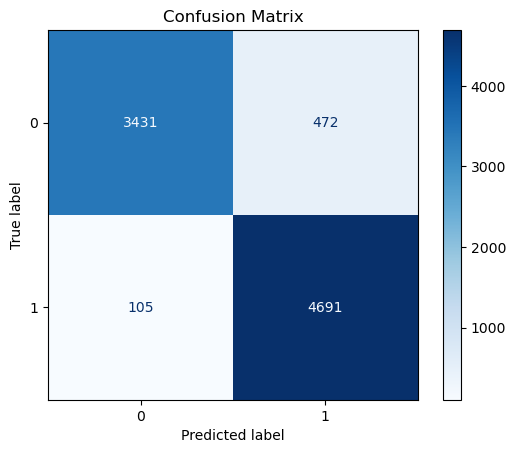

In [69]:
logis_model = train(texts_enc, dataset["class"], "Logistic")

##### Decision Tree

Accuracy:
0.8987239912633636


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3924
           1       0.91      0.91      0.91      4775

    accuracy                           0.90      8699
   macro avg       0.90      0.90      0.90      8699
weighted avg       0.90      0.90      0.90      8699



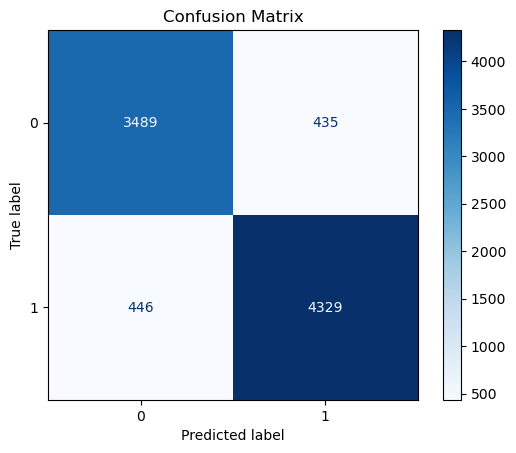

In [70]:
decis_model = train(texts_enc, dataset["class"], "Decision_Tree")

##### MLP Classifier

Accuracy:
0.967122657776756


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3950
           1       0.96      0.99      0.97      4749

    accuracy                           0.97      8699
   macro avg       0.97      0.97      0.97      8699
weighted avg       0.97      0.97      0.97      8699



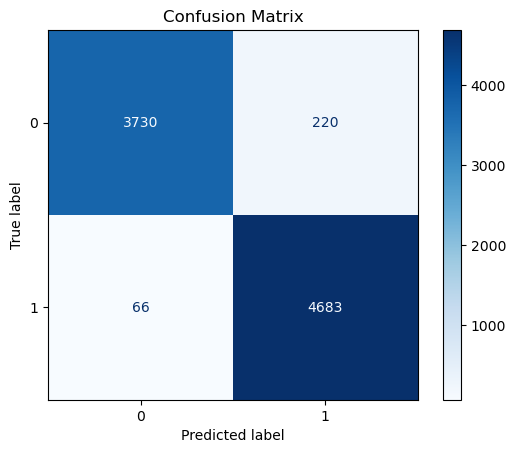

In [71]:
MLP_model = train(texts_enc, dataset["class"], "MLP")

##### Evaluate on the testing set

In [72]:
preprocessed_text_test = preprocess_text(testing_set['text'].values)

100%|██████████| 3865/3865 [00:00<00:00, 6134.98it/s]


In [73]:
word_to_index = {word: i for i, word in enumerate(words)}

batch_size = 70
num_batches = (len(preprocessed_text_test) + batch_size - 1) // batch_size

texts_enc_test = np.zeros((len(preprocessed_text_test), vector_dim))

for batch in tqdm(range(num_batches), total=num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(preprocessed_text_test))
    batch_texts = preprocessed_text_test[start_idx:end_idx]

    batch_enc = np.zeros((end_idx - start_idx, num_words))

    for j, text in enumerate(batch_texts):
        for count, word in enumerate(text, start=1):
            if word in words: ### in case that the word doesn't appear in the training set
                np.add.at(batch_enc[j], word_to_index[word], count)

    texts_enc_test[start_idx:end_idx] = batch_enc @ embedding_matrix

texts_enc_test

100%|██████████| 56/56 [02:26<00:00,  2.62s/it]


array([[ 4.69098479e+03,  1.81304224e+03,  2.88124663e+03, ...,
         3.58399995e+02, -7.00553006e+02,  1.18397095e+03],
       [-1.31045087e+04,  2.03057043e+04, -1.68429828e+04, ...,
         9.28656374e+04, -1.97327951e+04, -3.63182378e+04],
       [-3.37717266e+04,  6.31866137e+04, -6.18640441e+04, ...,
         8.07314892e+04,  2.46675045e+04, -2.15541491e+02],
       ...,
       [ 3.96115322e+04, -1.08115479e+05,  1.53462331e+04, ...,
         6.80358390e+04, -2.44464566e+04, -3.94992105e+03],
       [ 3.00167527e+05, -7.94447083e+04, -1.17517965e+05, ...,
         8.90057476e+04, -1.89831024e+05, -1.20072456e+05],
       [ 9.01026265e+03, -2.08379589e+04, -7.68126656e+03, ...,
        -4.97642899e+03, -2.65537259e+04, -1.31462406e+04]])

Accuracy:
0.7627425614489004


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1753
           1       0.92      0.62      0.74      2112

    accuracy                           0.76      3865
   macro avg       0.80      0.78      0.76      3865
weighted avg       0.81      0.76      0.76      3865



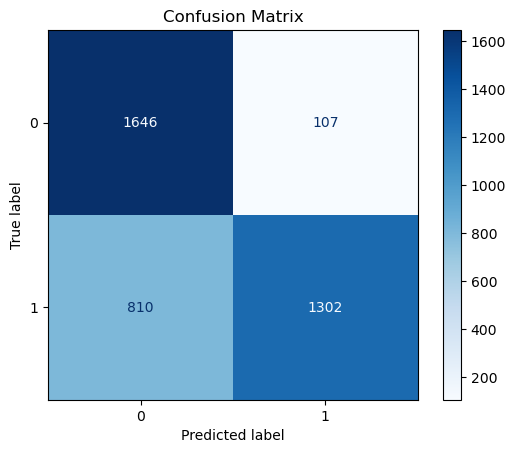

Metric  Count
0   True Positives (TP)   1302
1   True Negatives (TN)   1646
2  False Positives (FP)    107
3  False Negatives (FN)    810

In [74]:
printMetrics(testing_set["class"], logis_model.predict(texts_enc_test), method= "Logistic")

Accuracy:
0.7873221216041397


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1753
           1       0.94      0.65      0.77      2112

    accuracy                           0.79      3865
   macro avg       0.82      0.80      0.79      3865
weighted avg       0.83      0.79      0.78      3865



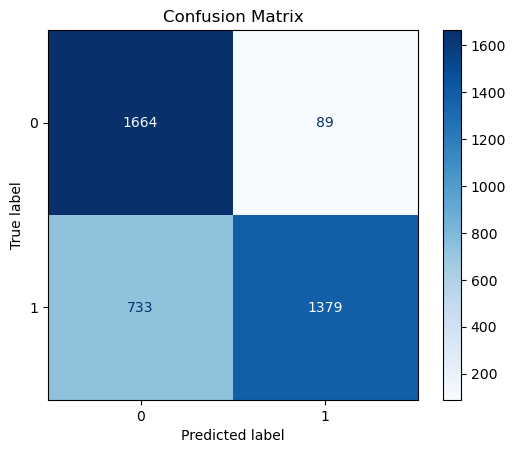

Metric  Count
0   True Positives (TP)   1379
1   True Negatives (TN)   1664
2  False Positives (FP)     89
3  False Negatives (FN)    733

In [75]:
printMetrics(testing_set["class"], decis_model.predict(texts_enc_test), method= "Decision_Tree")

In [76]:
printMetrics(testing_set["class"], MLP_model.predict(texts_enc_test), method= "MLP")

Accuracy:
0.8985769728331178


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1753
           1       0.95      0.86      0.90      2112

    accuracy                           0.90      3865
   macro avg       0.90      0.90      0.90      3865
weighted avg       0.90      0.90      0.90      3865



Metric  Count
0   True Positives (TP)   1818
1   True Negatives (TN)   1655
2  False Positives (FP)     98
3  False Negatives (FN)    294

##### Try different embedding dimensions

In [ ]:
from collections import Counter

embedding_dim_range = list(range(10, 71))
metrics_logis = {"accuracy": [], "tp": [], "fp": [], "fn": [], "tn": []}
metrics_decis = {"accuracy": [], "tp": [], "fp": [], "fn": [], "tn": []}
metrics_MLP = {"accuracy": [], "tp": [], "fp": [], "fn": [], "tn": []}

for vector_dim in tqdm(embedding_dim_range):
    model = Word2Vec(sentences=preprocessed_text, vector_size=vector_dim, window=10, min_count=1, workers=4, sg=0)
    embedding_matrix = model.wv.vectors
    words = model.wv.index_to_key
    word_to_index = {word: i for i, word in enumerate(words)}
    num_words = len(words)

    # Preprocess training texts
    texts_enc = np.zeros((len(preprocessed_text), vector_dim))
    for batch_start in range(0, len(preprocessed_text), 100):
        batch_texts = preprocessed_text[batch_start:batch_start + 100]
        batch_enc = np.zeros((len(batch_texts), num_words))

        for j, text in enumerate(batch_texts):
            word_counts = Counter(text)  # Count words efficiently
            for word, count in word_counts.items():
                if word in word_to_index:
                    batch_enc[j, word_to_index[word]] += count

        texts_enc[batch_start:batch_start + len(batch_texts)] = batch_enc @ embedding_matrix

    # Preprocess test texts
    preprocessed_text_test = preprocess_text(testing_set['text'].values, show_bar=False)
    texts_enc_test = np.zeros((len(preprocessed_text_test), vector_dim))
    for batch_start in range(0, len(preprocessed_text_test), 70):
        batch_texts = preprocessed_text_test[batch_start:batch_start + 70]
        batch_enc = np.zeros((len(batch_texts), num_words))

        for j, text in enumerate(batch_texts):
            word_counts = Counter(text)
            for word, count in word_counts.items():
                if word in word_to_index:
                    batch_enc[j, word_to_index[word]] += count

        texts_enc_test[batch_start:batch_start + len(batch_texts)] = batch_enc @ embedding_matrix

    # Train models
    logis_model = train(texts_enc, dataset["class"], "Logistic", show_metric=False)
    decis_model = train(texts_enc, dataset["class"], "Decision_Tree", show_metric=False)
    MLP_model = train(texts_enc, dataset["class"], "MLP", show_metric=False)

    # Predict and evaluate
    y_pred_logis = logis_model.predict(texts_enc_test)
    y_pred_decis = decis_model.predict(texts_enc_test)
    y_pred_MLP = MLP_model.predict(texts_enc_test)

    # Metrics calculation
    for model_name, y_pred, metrics in zip(["logis", "decis", "MLP"],
                                            [y_pred_logis, y_pred_decis, y_pred_MLP],
                                            [metrics_logis, metrics_decis, metrics_MLP]):
        test_accuracy = accuracy_score(testing_set["class"], y_pred)
        tn, fp, fn, tp = confusion_matrix(testing_set["class"], y_pred).ravel()

        metrics["accuracy"].append(test_accuracy)
        metrics["tn"].append(tn)
        metrics["fp"].append(fp)
        metrics["fn"].append(fn)
        metrics["tp"].append(tp)

100%|██████████| 61/61 [45:35<00:00, 44.85s/it]


In [ ]:
metrics_cbow = [metrics_logis, metrics_decis, metrics_MLP]
# Save metrics_cbow to a file
with open('saved/metrics_cbow.pkl', 'wb') as file:
    pickle.dump(metrics_cbow, file)

{'accuracy': [0.6628719275549806,
  0.586287192755498,
  0.6527813712807244,
  0.8010349288486417,
  0.658732212160414,
  0.645019404915912,
  0.6357050452781371,
  0.7296248382923674,
  0.79379042690815,
  0.6923673997412678,
  0.7870633893919793,
  0.7495472186287193,
  0.6978007761966365,
  0.7627425614489004,
  0.7373868046571799,
  0.6965071151358344,
  0.7389391979301423,
  0.7117723156532988,
  0.7089262613195343,
  0.628719275549806,
  0.6796895213454075,
  0.8297542043984476,
  0.6238033635187581,
  0.6388098318240621,
  0.7055627425614489,
  0.6957309184993532,
  0.6064683053040103,
  0.6654592496765848,
  0.6429495472186287,
  0.6623544631306598,
  0.7016817593790426,
  0.5979301423027167,
  0.6729624838292367,
  0.6745148771021993,
  0.7769728331177231,
  0.6644243208279431,
  0.5640362225097024,
  0.615006468305304,
  0.6719275549805951,
  0.777490297542044,
  0.8426908150064683,
  0.7102199223803364,
  0.7342820181112548,
  0.7857697283311772,
  0.6877102199223804,
  0.82

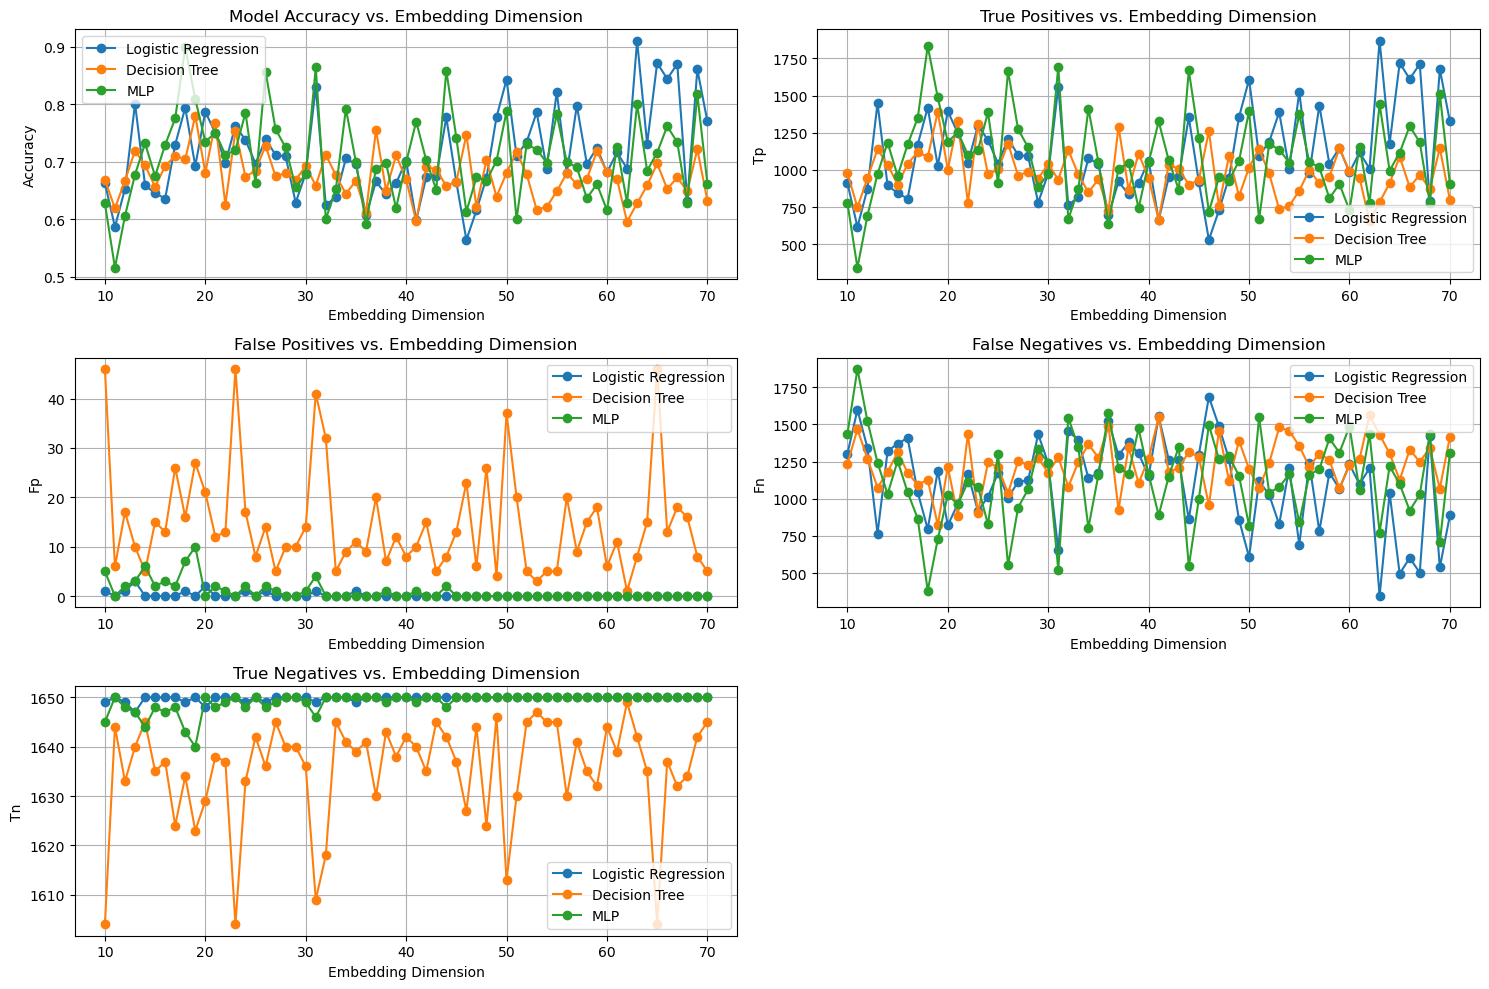

In [ ]:
# Prepare the metrics data and titles
metrics_data = {
    "accuracy": (metrics_logis["accuracy"], metrics_decis["accuracy"], metrics_MLP["accuracy"]),
    "tp": (metrics_logis["tp"], metrics_decis["tp"], metrics_MLP["tp"]),
    "fp": (metrics_logis["fp"], metrics_decis["fp"], metrics_MLP["fp"]),
    "fn": (metrics_logis["fn"], metrics_decis["fn"], metrics_MLP["fn"]),
    "tn": (metrics_logis["tn"], metrics_decis["tn"], metrics_MLP["tn"]),
}

titles = {
    "accuracy": 'Model Accuracy vs. Embedding Dimension',
    "tp": 'True Positives vs. Embedding Dimension',
    "fp": 'False Positives vs. Embedding Dimension',
    "fn": 'False Negatives vs. Embedding Dimension',
    "tn": 'True Negatives vs. Embedding Dimension',
}

# Set up the figure
plt.figure(figsize=(15, 10))

# Loop through each metric and plot
for i, (metric, (logis, decis, mlp)) in enumerate(metrics_data.items()):
    plt.subplot(3, 2, i + 1)
    plt.plot(embedding_dim_range, logis, label='Logistic Regression', marker='o')
    plt.plot(embedding_dim_range, decis, label='Decision Tree', marker='o')
    plt.plot(embedding_dim_range, mlp, label='MLP', marker='o')

    plt.title(titles[metric])
    plt.xlabel('Embedding Dimension')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [123]:
# load it
with open('saved/metrics_cbow.pkl', 'rb') as file:
    loaded_metrics_cbow = pickle.load(file)


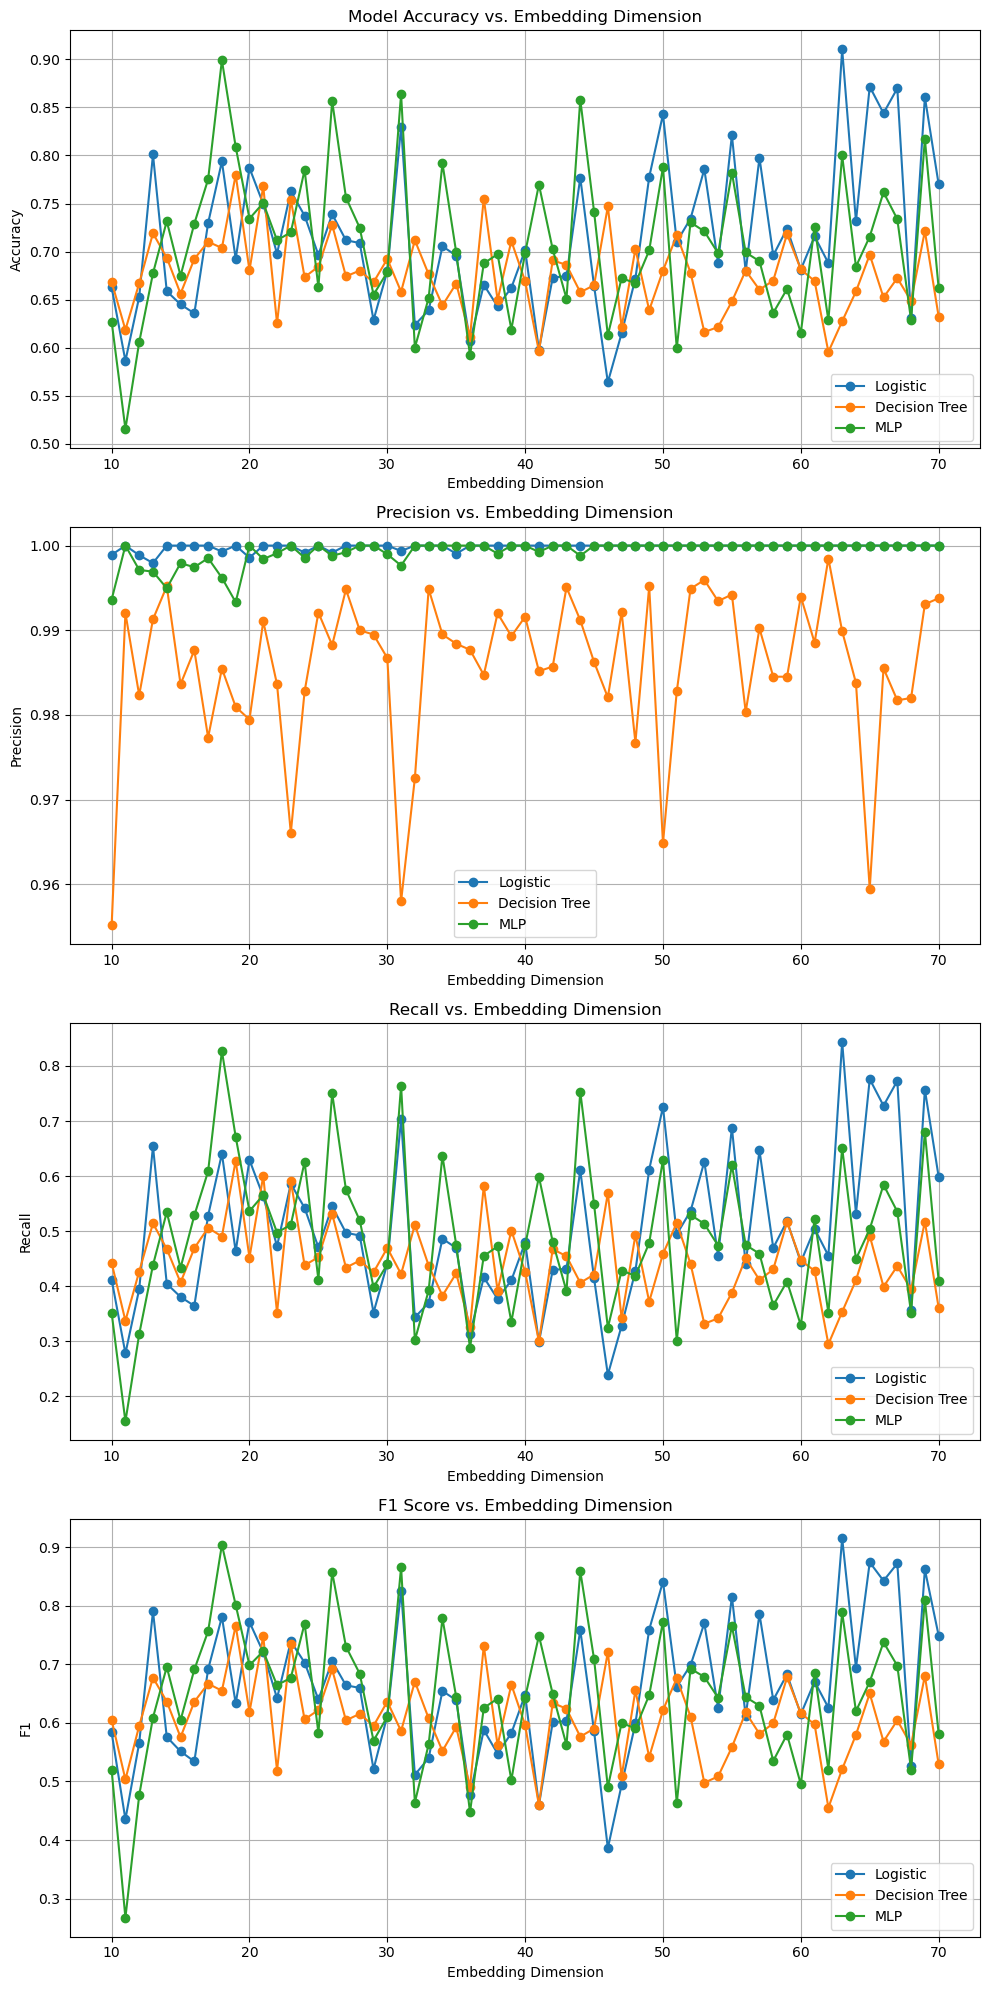

In [124]:
metrics_logis = loaded_metrics_cbow[0]
metrics_decis = loaded_metrics_cbow[1]
metrics_MLP = loaded_metrics_cbow[2]

embedding_dim_range = list(range(10, 71))

# Prepare the metrics data
metrics_data = {
    "accuracy": (metrics_logis["accuracy"], metrics_decis["accuracy"], metrics_MLP["accuracy"]),
    "tp": (metrics_logis["tp"], metrics_decis["tp"], metrics_MLP["tp"]),
    "fp": (metrics_logis["fp"], metrics_decis["fp"], metrics_MLP["fp"]),
    "fn": (metrics_logis["fn"], metrics_decis["fn"], metrics_MLP["fn"]),
}

# Calculate precision, recall, and F1-score
precision_logis = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(metrics_logis["tp"], metrics_logis["fp"])]
precision_decis = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(metrics_decis["tp"], metrics_decis["fp"])]
precision_MLP = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(metrics_MLP["tp"], metrics_MLP["fp"])]

recall_logis = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(metrics_logis["tp"], metrics_logis["fn"])]
recall_decis = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(metrics_decis["tp"], metrics_decis["fn"])]
recall_MLP = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(metrics_MLP["tp"], metrics_MLP["fn"])]

f1_logis = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_logis, recall_logis)]
f1_decis = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_decis, recall_decis)]
f1_MLP = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_MLP, recall_MLP)]

# Prepare the full metrics data for plotting
metrics_plot_data = {
    "accuracy": metrics_data["accuracy"],
    "precision": (precision_logis, precision_decis, precision_MLP),
    "recall": (recall_logis, recall_decis, recall_MLP),
    "f1": (f1_logis, f1_decis, f1_MLP),
}

titles = {
    "accuracy": 'Model Accuracy vs. Embedding Dimension',
    "precision": 'Precision vs. Embedding Dimension',
    "recall": 'Recall vs. Embedding Dimension',
    "f1": 'F1 Score vs. Embedding Dimension',
}

# Create subplots for each metric
num_metrics = len(metrics_plot_data)
fig, axs = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics))

for i, (metric_name, data) in enumerate(metrics_plot_data.items()):
    # Plot each model's metric against the embedding dimension
    axs[i].plot(embedding_dim_range, data[0], label='Logistic', marker='o')
    axs[i].plot(embedding_dim_range, data[1], label='Decision Tree', marker='o')
    axs[i].plot(embedding_dim_range, data[2], label='MLP', marker='o')
    
    # Set titles and labels
    axs[i].set_title(titles[metric_name])
    axs[i].set_xlabel('Embedding Dimension')
    axs[i].set_ylabel(metric_name.capitalize())
    axs[i].legend()
    axs[i].grid()

# Adjust layout
plt.tight_layout()
plt.show()

### By SkipGram

In [77]:
model = Word2Vec(sentences=preprocessed_text, vector_size=vector_dim, window=10, min_count=1, workers=4, sg=1)  #sg= 1 means using Skip-Gram,

In [78]:
sims = model.wv.most_similar('Hitler', topn=20)  # get other similar words
sims

[('Adolf', 0.9087054133415222),
 ('Mussolini', 0.7510694265365601),
 ('Benito', 0.7269229292869568),
 ('Nazi', 0.7208755612373352),
 ('Adolph', 0.6995347738265991),
 ('Heil', 0.6892797350883484),
 ('Holocaust', 0.67987459897995),
 ('Goebbels', 0.6741002798080444),
 ('Brownshirts', 0.6609030961990356),
 ('gassing', 0.6567473411560059),
 ('gassed', 0.6544652581214905),
 ('bedside', 0.6493093371391296),
 ('Nazis', 0.6479257345199585),
 ('demagogues', 0.6365208625793457),
 ('evocative', 0.6304845809936523),
 ('hypnotic', 0.6237999796867371),
 ('jews', 0.6228004693984985),
 ('Jews', 0.6159703135490417),
 ('Gestapo', 0.6154178380966187),
 ('eerily', 0.6134331226348877)]

#### Texts Embedding

In [79]:
word_to_index = {word: i for i, word in enumerate(words)}

batch_size = 100
num_batches = (len(preprocessed_text) + batch_size - 1) // batch_size

texts_enc = np.zeros((len(preprocessed_text), vector_dim))

for batch in tqdm(range(num_batches), total=num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(preprocessed_text))
    batch_texts = preprocessed_text[start_idx:end_idx]

    batch_enc = np.zeros((end_idx - start_idx, num_words))

    for j, text in enumerate(batch_texts):
        for count, word in enumerate(text, start=1):
            np.add.at(batch_enc[j], word_to_index[word], count)

    texts_enc[start_idx:end_idx] = batch_enc @ embedding_matrix

texts_enc

100%|██████████| 348/348 [00:46<00:00,  7.44it/s]


array([[-15920.59799691,  10674.60848354,  -4343.39139225, ...,
          6089.27598595,   8631.56412642,   -172.78901464],
       [ 13872.14109055, -18560.22663235,  -3157.50802483, ...,
         40627.27228459, -10295.41953031, -25379.62571136],
       [ 27339.24612278, -52391.61998092,  69461.84347237, ...,
         33389.09859746,  -3237.42369635, -18577.01687997],
       ...,
       [  2641.43137528, -22052.93153152,  36777.47141854, ...,
        -28258.9860476 , -29659.51279484,  -6915.64350251],
       [  3460.88984483, -10188.55729168,  -4705.12961481, ...,
          6712.60087919, -36836.04412129, -16887.01518461],
       [ 32897.84739027, -55091.17235273,   5723.28818742, ...,
           958.35129081, -33794.11699736, -59219.80671374]])

##### Logistic Regression

Accuracy:
0.9336705368433154


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3967
           1       0.91      0.98      0.94      4732

    accuracy                           0.93      8699
   macro avg       0.94      0.93      0.93      8699
weighted avg       0.94      0.93      0.93      8699



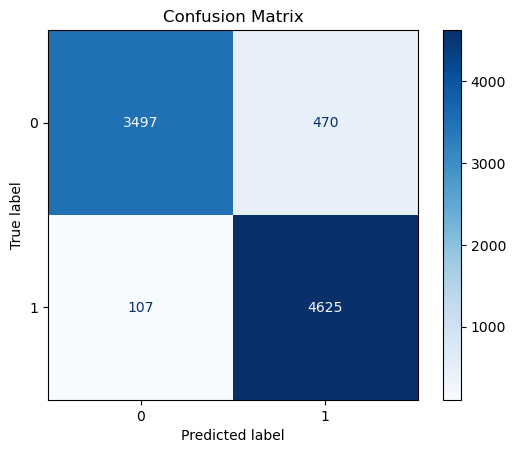

In [80]:
logis_model = train(texts_enc, dataset["class"], "Logistic")

##### Decision Tree

Accuracy:
0.8952753190021842


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3978
           1       0.90      0.90      0.90      4721

    accuracy                           0.90      8699
   macro avg       0.89      0.89      0.89      8699
weighted avg       0.90      0.90      0.90      8699



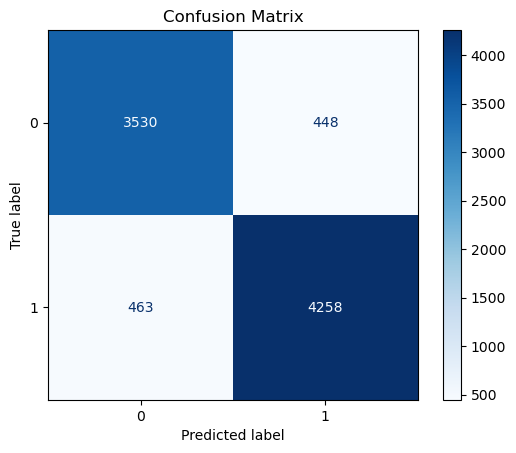

In [81]:
decis_model = train(texts_enc, dataset["class"], "Decision_Tree")

##### MLP Classifier

Accuracy:
0.966777790550638


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3909
           1       0.97      0.97      0.97      4790

    accuracy                           0.97      8699
   macro avg       0.97      0.97      0.97      8699
weighted avg       0.97      0.97      0.97      8699



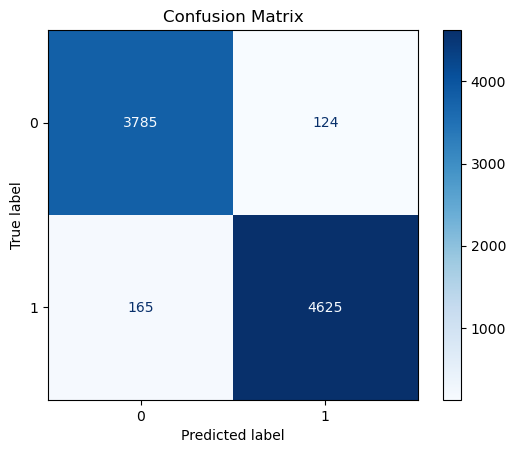

In [82]:
MLP_model = train(texts_enc, dataset["class"], "MLP")

##### Evaluate on the testing set

In [83]:
preprocessed_text_test = preprocess_text(testing_set['text'].values)

100%|██████████| 3865/3865 [00:00<00:00, 6053.22it/s]


In [84]:
word_to_index = {word: i for i, word in enumerate(words)}

batch_size = 70
num_batches = (len(preprocessed_text_test) + batch_size - 1) // batch_size

texts_enc_test = np.zeros((len(preprocessed_text_test), vector_dim))

for batch in tqdm(range(num_batches), total=num_batches):
    start_idx = batch * batch_size
    end_idx = min(start_idx + batch_size, len(preprocessed_text_test))
    batch_texts = preprocessed_text_test[start_idx:end_idx]

    batch_enc = np.zeros((end_idx - start_idx, num_words))

    for j, text in enumerate(batch_texts):
        for count, word in enumerate(text, start=1):
            if word in words: ### in case that the word doesn't appear in the training set
                np.add.at(batch_enc[j], word_to_index[word], count)

    texts_enc_test[start_idx:end_idx] = batch_enc @ embedding_matrix

texts_enc_test

100%|██████████| 56/56 [02:26<00:00,  2.62s/it]


array([[ 4.69098479e+03,  1.81304224e+03,  2.88124663e+03, ...,
         3.58399995e+02, -7.00553006e+02,  1.18397095e+03],
       [-1.31045087e+04,  2.03057043e+04, -1.68429828e+04, ...,
         9.28656374e+04, -1.97327951e+04, -3.63182378e+04],
       [-3.37717266e+04,  6.31866137e+04, -6.18640441e+04, ...,
         8.07314892e+04,  2.46675045e+04, -2.15541491e+02],
       ...,
       [ 3.96115322e+04, -1.08115479e+05,  1.53462331e+04, ...,
         6.80358390e+04, -2.44464566e+04, -3.94992105e+03],
       [ 3.00167527e+05, -7.94447083e+04, -1.17517965e+05, ...,
         8.90057476e+04, -1.89831024e+05, -1.20072456e+05],
       [ 9.01026265e+03, -2.08379589e+04, -7.68126656e+03, ...,
        -4.97642899e+03, -2.65537259e+04, -1.31462406e+04]])

Accuracy:
0.7759379042690815


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.68      0.94      0.79      1753
           1       0.93      0.64      0.76      2112

    accuracy                           0.78      3865
   macro avg       0.81      0.79      0.77      3865
weighted avg       0.82      0.78      0.77      3865



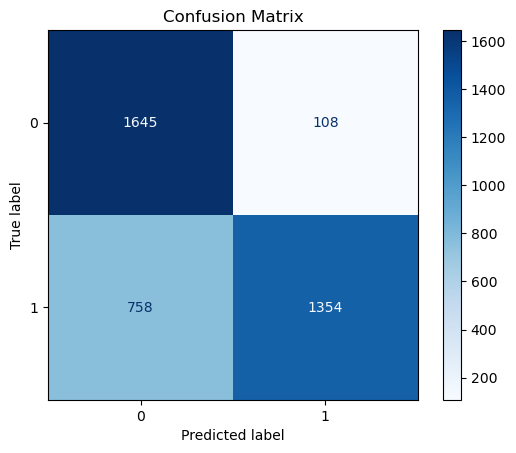

Metric  Count
0   True Positives (TP)   1354
1   True Negatives (TN)   1645
2  False Positives (FP)    108
3  False Negatives (FN)    758

In [85]:
printMetrics(testing_set["class"], logis_model.predict(texts_enc_test), method= "Logistic")

Accuracy:
0.7609314359637774


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1753
           1       0.95      0.60      0.73      2112

    accuracy                           0.76      3865
   macro avg       0.81      0.78      0.76      3865
weighted avg       0.82      0.76      0.76      3865



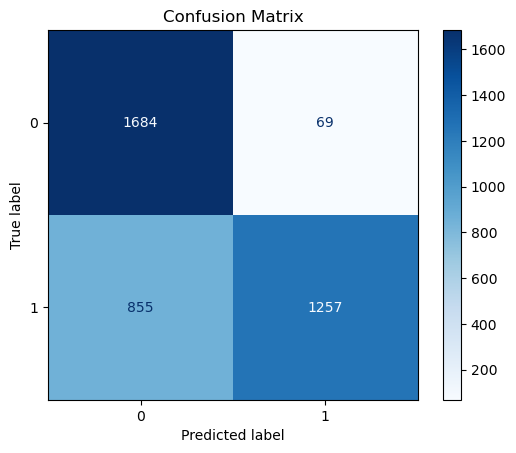

Metric  Count
0   True Positives (TP)   1257
1   True Negatives (TN)   1684
2  False Positives (FP)     69
3  False Negatives (FN)    855

In [86]:
printMetrics(testing_set["class"], decis_model.predict(texts_enc_test), method= "Decision_Tree")

In [87]:
printMetrics(testing_set["class"], MLP_model.predict(texts_enc_test), method= "MLP")

Accuracy:
0.8902975420439845


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1753
           1       0.98      0.81      0.89      2112

    accuracy                           0.89      3865
   macro avg       0.90      0.90      0.89      3865
weighted avg       0.91      0.89      0.89      3865



Metric  Count
0   True Positives (TP)   1721
1   True Negatives (TN)   1720
2  False Positives (FP)     33
3  False Negatives (FN)    391

##### Try different embedding dimensions

In [ ]:
from collections import Counter

embedding_dim_range = list(range(10, 71))
metrics_logis = {"accuracy": [], "tp": [], "fp": [], "fn": [], "tn": []}
metrics_decis = {"accuracy": [], "tp": [], "fp": [], "fn": [], "tn": []}
metrics_MLP = {"accuracy": [], "tp": [], "fp": [], "fn": [], "tn": []}

for vector_dim in tqdm(embedding_dim_range):
    model = Word2Vec(sentences=preprocessed_text, vector_size=vector_dim, window=10, min_count=1, workers=4, sg=1) # try skip gram
    embedding_matrix = model.wv.vectors
    words = model.wv.index_to_key
    word_to_index = {word: i for i, word in enumerate(words)}
    num_words = len(words)

    # Preprocess training texts
    texts_enc = np.zeros((len(preprocessed_text), vector_dim))
    for batch_start in range(0, len(preprocessed_text), 100):
        batch_texts = preprocessed_text[batch_start:batch_start + 100]
        batch_enc = np.zeros((len(batch_texts), num_words))

        for j, text in enumerate(batch_texts):
            word_counts = Counter(text)  # Count words efficiently
            for word, count in word_counts.items():
                if word in word_to_index:
                    batch_enc[j, word_to_index[word]] += count

        texts_enc[batch_start:batch_start + len(batch_texts)] = batch_enc @ embedding_matrix

    # Preprocess test texts
    preprocessed_text_test = preprocess_text(testing_set['text'].values, show_bar=False)
    texts_enc_test = np.zeros((len(preprocessed_text_test), vector_dim))
    for batch_start in range(0, len(preprocessed_text_test), 70):
        batch_texts = preprocessed_text_test[batch_start:batch_start + 70]
        batch_enc = np.zeros((len(batch_texts), num_words))

        for j, text in enumerate(batch_texts):
            word_counts = Counter(text)
            for word, count in word_counts.items():
                if word in word_to_index:
                    batch_enc[j, word_to_index[word]] += count

        texts_enc_test[batch_start:batch_start + len(batch_texts)] = batch_enc @ embedding_matrix

    # Train models
    logis_model = train(texts_enc, dataset["class"], "Logistic", show_metric=False)
    decis_model = train(texts_enc, dataset["class"], "Decision_Tree", show_metric=False)
    MLP_model = train(texts_enc, dataset["class"], "MLP", show_metric=False)

    # Predict and evaluate
    y_pred_logis = logis_model.predict(texts_enc_test)
    y_pred_decis = decis_model.predict(texts_enc_test)
    y_pred_MLP = MLP_model.predict(texts_enc_test)

    # Metrics calculation
    for model_name, y_pred, metrics in zip(["logis", "decis", "MLP"],
                                            [y_pred_logis, y_pred_decis, y_pred_MLP],
                                            [metrics_logis, metrics_decis, metrics_MLP]):
        test_accuracy = accuracy_score(testing_set["class"], y_pred)
        tn, fp, fn, tp = confusion_matrix(testing_set["class"], y_pred).ravel()

        metrics["accuracy"].append(test_accuracy)
        metrics["tn"].append(tn)
        metrics["fp"].append(fp)
        metrics["fn"].append(fn)
        metrics["tp"].append(tp)

100%|██████████| 61/61 [2:09:16<00:00, 127.15s/it]  


In [ ]:
metrics_sg = [metrics_logis, metrics_decis, metrics_MLP]
# Save metrics_sg to a file
with open('saved/metrics_sg.pkl', 'wb') as file:
    pickle.dump(metrics_sg, file)

"\n# load it\nwith open('saved/metrics_sg.pkl', 'rb') as file:\n    loaded_metrics_sg = pickle.load(file)\n"

In [ ]:
# Prepare the metrics data and titles
metrics_data = {
    "accuracy": (metrics_logis["accuracy"], metrics_decis["accuracy"], metrics_MLP["accuracy"]),
    "tp": (metrics_logis["tp"], metrics_decis["tp"], metrics_MLP["tp"]),
    "fp": (metrics_logis["fp"], metrics_decis["fp"], metrics_MLP["fp"]),
    "fn": (metrics_logis["fn"], metrics_decis["fn"], metrics_MLP["fn"]),
    "tn": (metrics_logis["tn"], metrics_decis["tn"], metrics_MLP["tn"]),
}

titles = {
    "accuracy": 'Model Accuracy vs. Embedding Dimension',
    "tp": 'True Positives vs. Embedding Dimension',
    "fp": 'False Positives vs. Embedding Dimension',
    "fn": 'False Negatives vs. Embedding Dimension',
    "tn": 'True Negatives vs. Embedding Dimension',
}

# Set up the figure
plt.figure(figsize=(15, 10))

# Loop through each metric and plot
for i, (metric, (logis, decis, mlp)) in enumerate(metrics_data.items()):
    plt.subplot(3, 2, i + 1)
    plt.plot(embedding_dim_range, logis, label='Logistic Regression', marker='o')
    plt.plot(embedding_dim_range, decis, label='Decision Tree', marker='o')
    plt.plot(embedding_dim_range, mlp, label='MLP', marker='o')

    plt.title(titles[metric])
    plt.xlabel('Embedding Dimension')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [125]:
# load it
with open('saved/metrics_sg.pkl', 'rb') as file:
    loaded_metrics_sg = pickle.load(file)

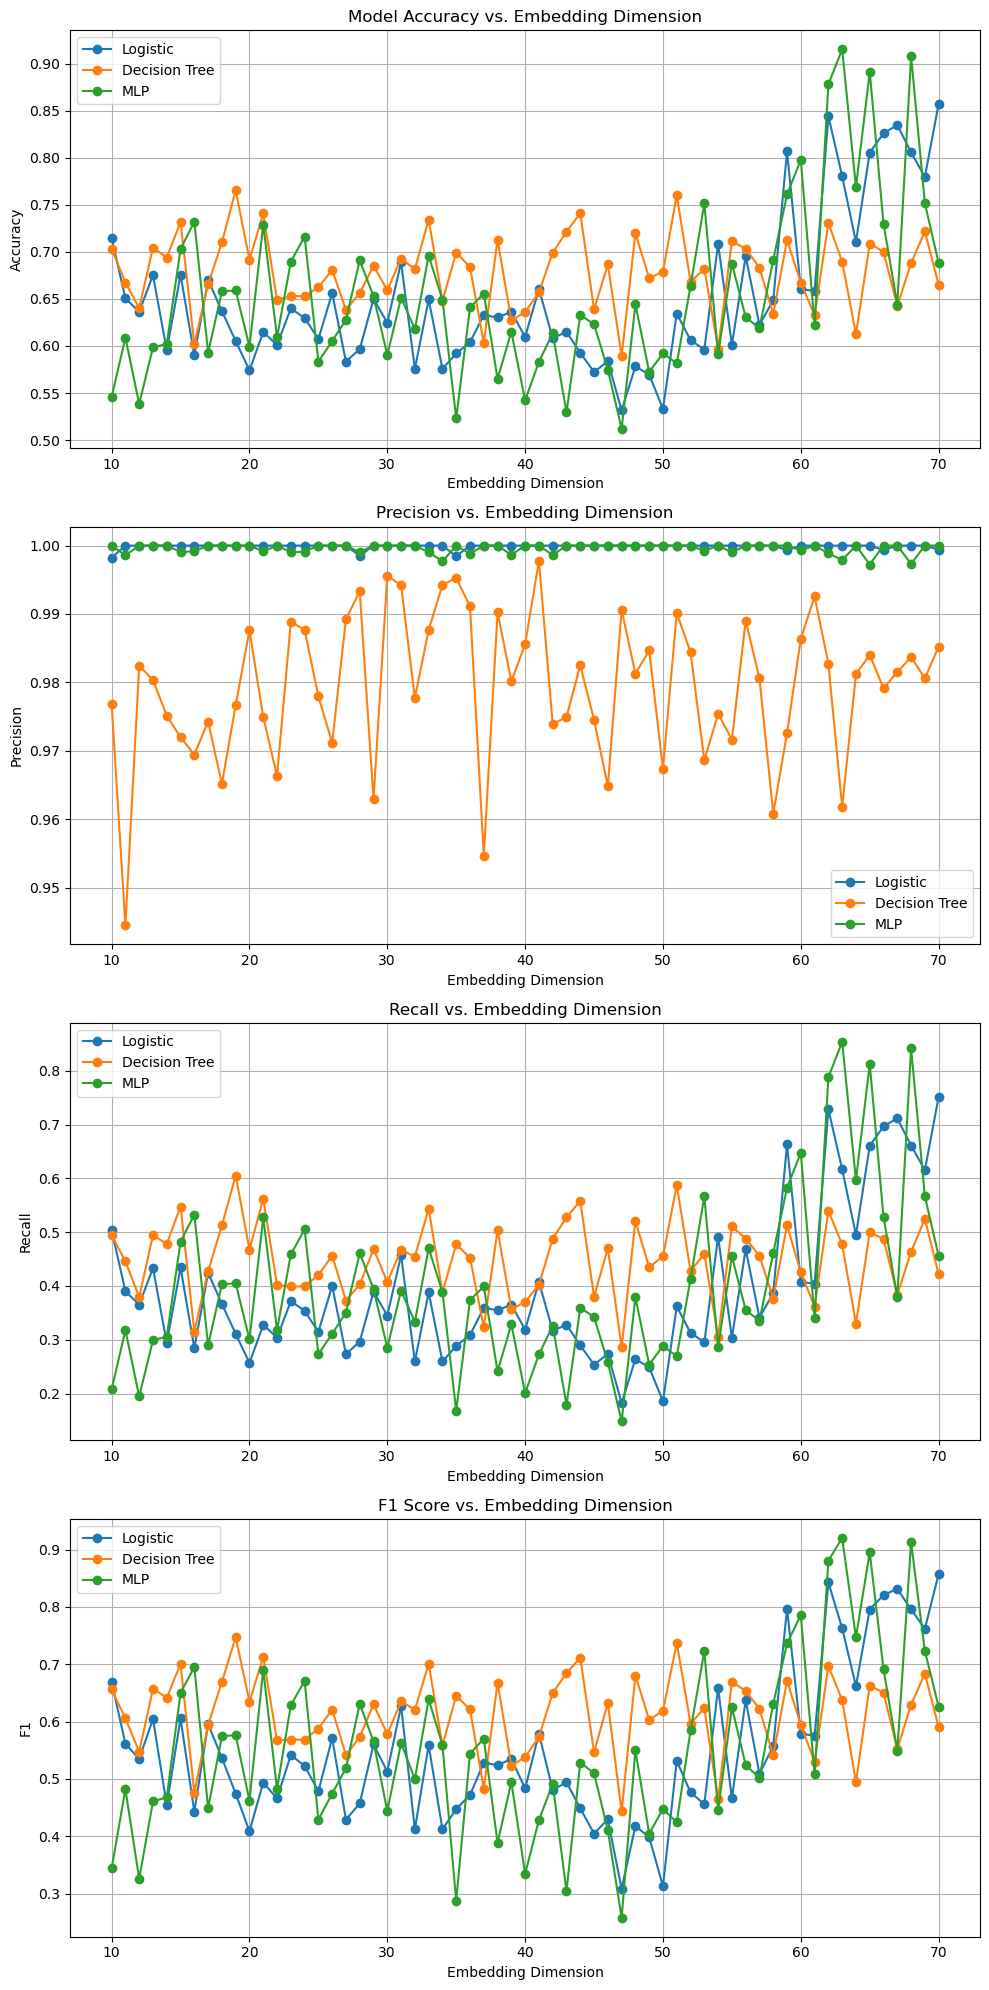

In [126]:
metrics_logis = loaded_metrics_sg[0]
metrics_decis = loaded_metrics_sg[1]
metrics_MLP = loaded_metrics_sg[2]

embedding_dim_range = list(range(10, 71))

# Prepare the metrics data
metrics_data = {
    "accuracy": (metrics_logis["accuracy"], metrics_decis["accuracy"], metrics_MLP["accuracy"]),
    "tp": (metrics_logis["tp"], metrics_decis["tp"], metrics_MLP["tp"]),
    "fp": (metrics_logis["fp"], metrics_decis["fp"], metrics_MLP["fp"]),
    "fn": (metrics_logis["fn"], metrics_decis["fn"], metrics_MLP["fn"]),
}

# Calculate precision, recall, and F1-score
precision_logis = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(metrics_logis["tp"], metrics_logis["fp"])]
precision_decis = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(metrics_decis["tp"], metrics_decis["fp"])]
precision_MLP = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(metrics_MLP["tp"], metrics_MLP["fp"])]

recall_logis = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(metrics_logis["tp"], metrics_logis["fn"])]
recall_decis = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(metrics_decis["tp"], metrics_decis["fn"])]
recall_MLP = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(metrics_MLP["tp"], metrics_MLP["fn"])]

f1_logis = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_logis, recall_logis)]
f1_decis = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_decis, recall_decis)]
f1_MLP = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_MLP, recall_MLP)]

# Prepare the full metrics data for plotting
metrics_plot_data = {
    "accuracy": metrics_data["accuracy"],
    "precision": (precision_logis, precision_decis, precision_MLP),
    "recall": (recall_logis, recall_decis, recall_MLP),
    "f1": (f1_logis, f1_decis, f1_MLP),
}

titles = {
    "accuracy": 'Model Accuracy vs. Embedding Dimension',
    "precision": 'Precision vs. Embedding Dimension',
    "recall": 'Recall vs. Embedding Dimension',
    "f1": 'F1 Score vs. Embedding Dimension',
}

# Create subplots for each metric
num_metrics = len(metrics_plot_data)
fig, axs = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics))

for i, (metric_name, data) in enumerate(metrics_plot_data.items()):
    # Plot each model's metric against the embedding dimension
    axs[i].plot(embedding_dim_range, data[0], label='Logistic', marker='o')
    axs[i].plot(embedding_dim_range, data[1], label='Decision Tree', marker='o')
    axs[i].plot(embedding_dim_range, data[2], label='MLP', marker='o')
    
    # Set titles and labels
    axs[i].set_title(titles[metric_name])
    axs[i].set_xlabel('Embedding Dimension')
    axs[i].set_ylabel(metric_name.capitalize())
    axs[i].legend()
    axs[i].grid()

# Adjust layout
plt.tight_layout()
plt.show()

## Pre-trained model `GloVe`
In this section, we will use the pre-trained model `Global Vectors for Word Representation (GloVe)`

In [88]:
def preprocess_text(text):
    # Replace apostrophes with spaces “”
    text = re.sub("’", " ", text)
    text = re.sub("“", " ", text)
    text = re.sub("”", " ", text)
    return text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['text'].apply(preprocess_text))

word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

116829

In [89]:
sequences = tokenizer.texts_to_sequences(dataset['text'].apply(preprocess_text))
padded_seq = pad_sequences(sequences, maxlen=max(len(data) for data in dataset['text'].apply(preprocess_text)), padding='post', truncating='post')

In [90]:
# create embedding index
embedding_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 50))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    #if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [91]:
num_sequences = len(padded_seq)
max_sequence_length = len(padded_seq[0])
embedding_dim = 50

# Initialize the output array
texts_enc = np.zeros((len(padded_seq), embedding_dim))

# Compute the encodings
for index, seq in tqdm(enumerate(padded_seq)):
    first_zero_index = np.where(seq == 0)[0][0] if 0 in seq else len(seq)
    non_zero_indices = np.arange(first_zero_index)  # Get indices of non-zero elements

    # Filter out NaN values in the embeddings
    valid_indices = non_zero_indices[~np.isnan(embedding_matrix[seq[non_zero_indices]]).any(axis=1)] # in case that some words do not appear in GloVe
    valid_embeddings = embedding_matrix[seq[valid_indices]]  # Get the valid embeddings

    # Compute weighted sum only for valid embeddings
    weights = valid_indices + 1
    result = np.sum(valid_embeddings * weights[:, None], axis=0)

    texts_enc[index] = result

# Display the result
print(texts_enc[:5])

34793it [00:04, 8193.06it/s] 

[[ 2.88234501e+03  4.79346447e+03 -2.18203236e+03 -3.06495099e+03
   1.05846395e+04  1.10124578e+03 -1.10157876e+04 -8.26385666e+02
  -5.18125718e+03  3.79365597e+03 -1.79767344e+03  5.63710212e+03
  -6.87515467e+03  1.76821021e+02  1.34752286e+04  3.47236545e+03
   4.16694296e+02  1.22596307e+03 -1.44867596e+03 -7.53377260e+03
  -1.26191446e+03  8.53588272e+03  4.40489663e+03  4.27321193e+03
   8.55523676e+03 -2.76889130e+04 -1.23762788e+04  2.54295689e+03
   7.46380042e+03 -8.31583825e+03  4.98661861e+04  5.82501503e+03
  -3.79323420e+03 -2.95355941e+03 -8.62555055e+02 -1.17229538e+03
   6.14770600e+02  4.77140469e+03 -9.26766380e+02 -8.14946082e+03
  -8.47047561e+02  2.89224875e+03 -3.11321133e+03  1.55584118e+03
   1.82151942e+03  1.97991750e+02 -2.15799583e+03 -6.27392450e+03
  -2.40560527e+02  7.26646682e+03]
 [ 3.79222081e+03 -1.51450370e+03  1.26897979e+04 -4.71731370e+03
   6.46996003e+03  9.44567243e+03 -1.24997482e+04 -1.97462936e+03
  -6.37033577e+03 -5.41012428e+03 -1.3528

#### Logistic regression

c:\Users\calla\anaconda3\envs\COMP4211\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:
0.8750431084032647


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      3881
           1       0.85      0.94      0.89      4818

    accuracy                           0.88      8699
   macro avg       0.88      0.87      0.87      8699
weighted avg       0.88      0.88      0.87      8699



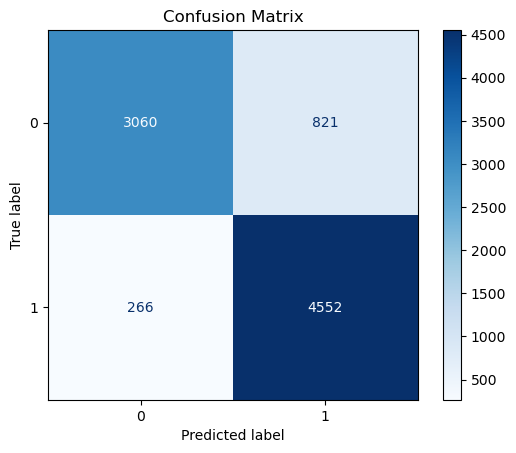

In [92]:
logis_model = train(texts_enc, dataset["class"], "Logistic")

#### Decison Tree

Accuracy:
0.8595240832279573


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3932
           1       0.87      0.87      0.87      4767

    accuracy                           0.86      8699
   macro avg       0.86      0.86      0.86      8699
weighted avg       0.86      0.86      0.86      8699



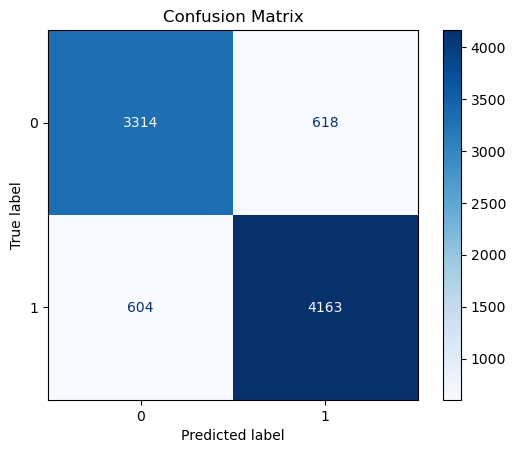

In [93]:
decis_model = train(texts_enc, dataset["class"], "Decision_Tree")

#### MLP Classifier

In [94]:
MLP_model = train(texts_enc, dataset["class"], "MLP")

Accuracy:
0.9127485917921601


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3946
           1       0.88      0.97      0.92      4753

    accuracy                           0.91      8699
   macro avg       0.92      0.91      0.91      8699
weighted avg       0.92      0.91      0.91      8699



#### Evaluate on the testing set

In [95]:
testing_set

text  class
40690  MEXICO CITY (Reuters) - Mexican state oil comp...      1
14849  CAN WE JUST STOP ALLOWING Muslim Refugees and ...      0
2703   Donald Trump is either really desperate to mak...      0
7772   A Trio of Neo-Nazi, Confederate flag-waving wh...      0
30551  WASHINGTON (Reuters) - U.S. Vice President-ele...      1
...                                                  ...    ...
16233  President Trump s rally in FL on Saturday was ...      0
10814  It looks like Bill O Reilly is getting the las...      0
29916  WASHINGTON (Reuters) - Classified documents th...      1
33666  NEW YORK (Reuters) - Donald Trump’s presidenti...      1
38173  BEIJING (Reuters) - Chinese Foreign Minister W...      1

[3865 rows x 2 columns]

In [96]:
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(testing_set['text'].apply(preprocess_text))

word_index2 = tokenizer2.word_index
vocab_size2 = len(word_index2)
vocab_size2

41417

In [97]:
sequences2 = tokenizer2.texts_to_sequences(testing_set['text'].apply(preprocess_text))
padded_seq2 = pad_sequences(sequences2, maxlen=max(len(data) for data in testing_set['text'].apply(preprocess_text)), padding='post', truncating='post')

In [98]:
# create embedding index
embedding_index2 = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index2[word] = coefs

# create embedding matrix
embedding_matrix2 = np.zeros((vocab_size+1, 50))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    #if embedding_vector is not None:
    embedding_matrix2[i] = embedding_vector

In [99]:
num_sequences2 = len(padded_seq2)
max_sequence_length2 = len(padded_seq2[0])
embedding_dim = 50

# Initialize the output array
texts_enc_test = np.zeros((len(padded_seq2), embedding_dim))

# Compute the encodings
for index, seq in tqdm(enumerate(padded_seq2)):
    first_zero_index = np.where(seq == 0)[0][0] if 0 in seq else len(seq)
    non_zero_indices = np.arange(first_zero_index)  # Get indices of non-zero elements

    # Filter out NaN values in the embeddings
    valid_indices = non_zero_indices[~np.isnan(embedding_matrix2[seq[non_zero_indices]]).any(axis=1)] # in case that some words do not appear in GloVe
    valid_embeddings = embedding_matrix2[seq[valid_indices]]  # Get the valid embeddings

    # Compute weighted sum only for valid embeddings
    weights = valid_indices + 1
    result = np.sum(valid_embeddings * weights[:, None], axis=0)

    texts_enc_test[index] = result

# Display the result
print(texts_enc_test[:5])

3865it [00:00, 8240.61it/s]

[[ 1.20278591e+03  8.61459458e+02  2.31315812e+03  7.14136033e+02
   2.81827514e+03 -3.02288244e+02 -4.71187141e+03 -1.07850149e+03
  -1.26833598e+03 -1.04485735e+03 -3.41568727e+02  1.21683088e+02
  -3.51258700e+03 -1.22150337e+03  3.82697207e+03  1.91810496e+03
   5.16311967e+01 -5.74981972e+02 -2.54459741e+02 -2.39067339e+03
   7.19163798e+02  1.75251721e+03  9.87591726e+02 -1.28983263e+03
  -4.37711582e+02 -1.53296026e+04 -1.76842443e+03 -8.59889235e+02
  -7.57113300e+02 -6.24071903e+02  2.61695300e+04  1.80837415e+03
  -3.15363392e+03 -2.63927358e+03 -1.01953881e+03 -3.76998898e+03
  -5.02163389e+02  6.08870821e+02  5.84858927e+02 -1.62785179e+03
  -2.22457585e+03  1.14859679e+03  1.22554292e+03  8.43398841e+01
  -1.83649630e+02  9.87492618e+02 -4.70203956e+03  2.37851011e+03
  -7.38671377e+02  2.09384963e+03]
 [ 2.41070397e+04  9.45955723e+03  1.27126372e+04  1.91279319e+04
   4.46949201e+04  4.86762778e+03 -5.93328843e+04 -8.65219177e+03
  -2.01119445e+04 -2.18580120e+04 -2.2736

In [100]:
printMetrics(testing_set["class"], logis_model.predict(texts_enc_test), method= "Logistic")

Accuracy:
0.548771021992238


Classification Report: Logistic
              precision    recall  f1-score   support

           0       1.00      0.01      0.01      1753
           1       0.55      1.00      0.71      2112

    accuracy                           0.55      3865
   macro avg       0.77      0.50      0.36      3865
weighted avg       0.75      0.55      0.39      3865



Metric  Count
0   True Positives (TP)   2112
1   True Negatives (TN)      9
2  False Positives (FP)   1744
3  False Negatives (FN)      0

Accuracy:
0.5141009055627426


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.42      0.20      0.27      1753
           1       0.54      0.78      0.64      2112

    accuracy                           0.51      3865
   macro avg       0.48      0.49      0.45      3865
weighted avg       0.49      0.51      0.47      3865



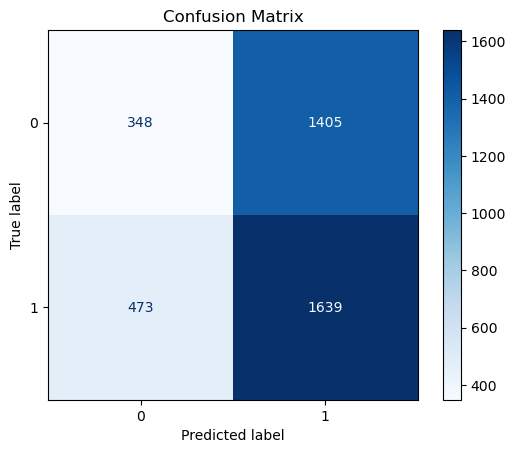

Metric  Count
0   True Positives (TP)   1639
1   True Negatives (TN)    348
2  False Positives (FP)   1405
3  False Negatives (FN)    473

In [101]:
printMetrics(testing_set["class"], decis_model.predict(texts_enc_test), method= "Decision_Tree")

In [102]:
printMetrics(testing_set["class"], MLP_model.predict(texts_enc_test), method= "MLP")

Accuracy:
0.5539456662354463


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.85      0.02      0.04      1753
           1       0.55      1.00      0.71      2112

    accuracy                           0.55      3865
   macro avg       0.70      0.51      0.37      3865
weighted avg       0.69      0.55      0.41      3865



Metric  Count
0   True Positives (TP)   2106
1   True Negatives (TN)     35
2  False Positives (FP)   1718
3  False Negatives (FN)      6

# Doc2Vec

## Distribued Memory

In [103]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tag each document with a unique identifier
tagged_data = [TaggedDocument(words=row['text'].split(), tags=[str(i)]) for i, row in dataset.iterrows()]

# Create and train the model
doc2vec = Doc2Vec(vector_size=50, min_count=1, epochs=1)
doc2vec.build_vocab(tagged_data)
doc2vec.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


In [104]:
# Get embeddings for each text
embeddings = [doc2vec.infer_vector(row['text'].split()) for _, row in tqdm(dataset.iterrows())]

34793it [01:16, 452.39it/s]


### Logistic regression

In [105]:
logis_model = train(embeddings, dataset["class"], method="Logistic")

Accuracy:
0.9339004483273939


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3911
           1       0.93      0.95      0.94      4788

    accuracy                           0.93      8699
   macro avg       0.93      0.93      0.93      8699
weighted avg       0.93      0.93      0.93      8699



### Decision Tree

In [106]:
decis_model = train(embeddings, dataset["class"], method="Decision_Tree")

Accuracy:
0.8371077135302908


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3952
           1       0.85      0.85      0.85      4747

    accuracy                           0.84      8699
   macro avg       0.84      0.84      0.84      8699
weighted avg       0.84      0.84      0.84      8699



### MLP

Accuracy:
0.9466605356937579


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3898
           1       0.95      0.95      0.95      4801

    accuracy                           0.95      8699
   macro avg       0.95      0.95      0.95      8699
weighted avg       0.95      0.95      0.95      8699



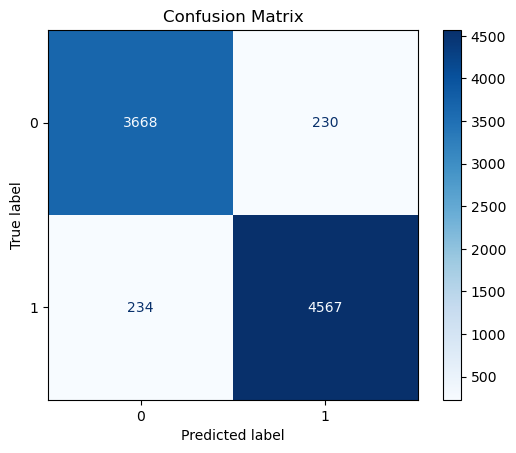

In [107]:
MLP_model = train(embeddings, dataset["class"], method="MLP")

### Evaluate on the testing set

In [108]:
embeddings2 = [doc2vec.infer_vector(row['text'].split()) for _, row in tqdm(testing_set.iterrows())]

3865it [00:09, 411.08it/s]


Accuracy:
0.9347994825355757


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1753
           1       0.93      0.95      0.94      2112

    accuracy                           0.93      3865
   macro avg       0.94      0.93      0.93      3865
weighted avg       0.93      0.93      0.93      3865



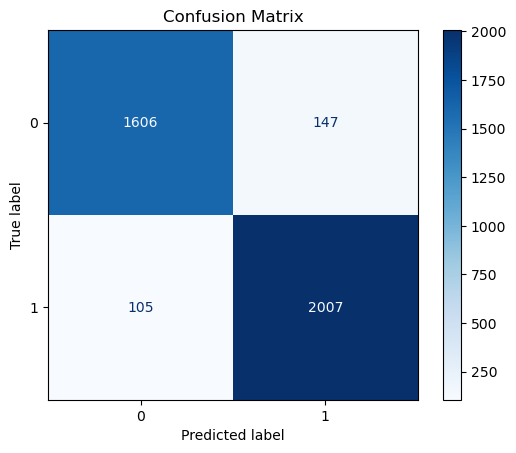

Metric  Count
0   True Positives (TP)   2007
1   True Negatives (TN)   1606
2  False Positives (FP)    147
3  False Negatives (FN)    105

In [109]:
printMetrics(testing_set["class"], logis_model.predict(embeddings2), method= "Logistic")

Accuracy:
0.8253557567917206


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1753
           1       0.85      0.83      0.84      2112

    accuracy                           0.83      3865
   macro avg       0.82      0.82      0.82      3865
weighted avg       0.83      0.83      0.83      3865



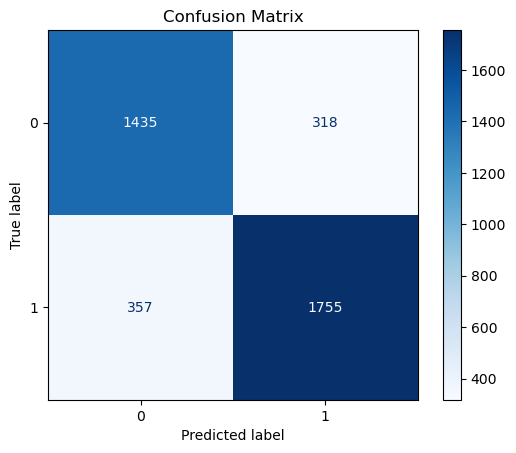

Metric  Count
0   True Positives (TP)   1755
1   True Negatives (TN)   1435
2  False Positives (FP)    318
3  False Negatives (FN)    357

In [110]:
printMetrics(testing_set["class"], decis_model.predict(embeddings2), method= "Decision_Tree")

Accuracy:
0.9490297542043985


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1753
           1       0.97      0.94      0.95      2112

    accuracy                           0.95      3865
   macro avg       0.95      0.95      0.95      3865
weighted avg       0.95      0.95      0.95      3865



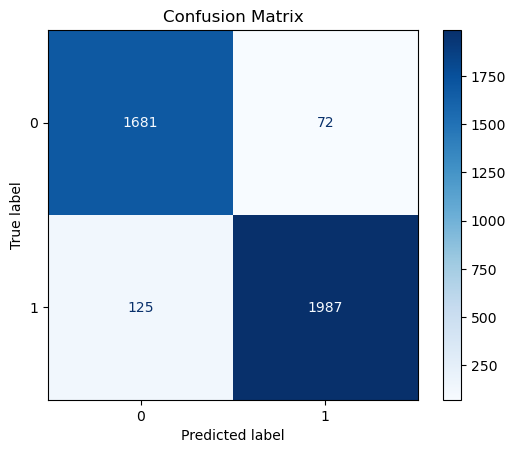

Metric  Count
0   True Positives (TP)   1987
1   True Negatives (TN)   1681
2  False Positives (FP)     72
3  False Negatives (FN)    125

In [111]:
printMetrics(testing_set["class"], MLP_model.predict(embeddings2), method= "MLP")

## Distributed Bag of Words

In [112]:
# Tag each document with a unique identifier
tagged_data = [TaggedDocument(words=row['text'].split(), tags=[str(i)]) for i, row in dataset.iterrows()]

# Create and train the model
doc2vec = Doc2Vec(vector_size=50, min_count=1, epochs=1, dm=0) # Distributed Memory by default
doc2vec.build_vocab(tagged_data)
doc2vec.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)


In [113]:
# Get embeddings for each text
embeddings = [doc2vec.infer_vector(row['text'].split()) for _, row in tqdm(dataset.iterrows())]

34793it [01:02, 559.01it/s]


### Logistic regression

Accuracy:
0.9948269916082308


Classification Report: Logistic
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3898
           1       0.99      1.00      1.00      4801

    accuracy                           0.99      8699
   macro avg       0.99      0.99      0.99      8699
weighted avg       0.99      0.99      0.99      8699



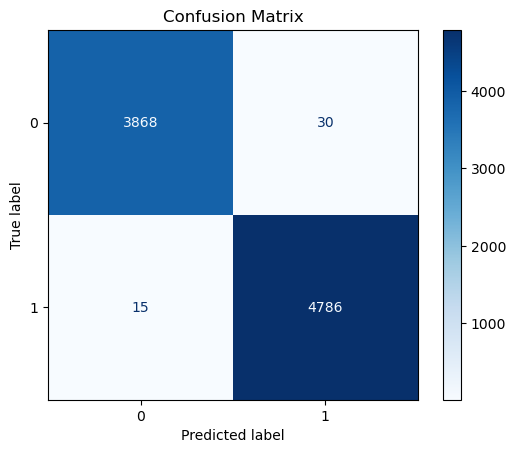

In [114]:
logis_model = train(embeddings, dataset["class"], method="Logistic")

### Decision Tree

Accuracy:
0.9397631911713991


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3936
           1       0.94      0.95      0.95      4763

    accuracy                           0.94      8699
   macro avg       0.94      0.94      0.94      8699
weighted avg       0.94      0.94      0.94      8699



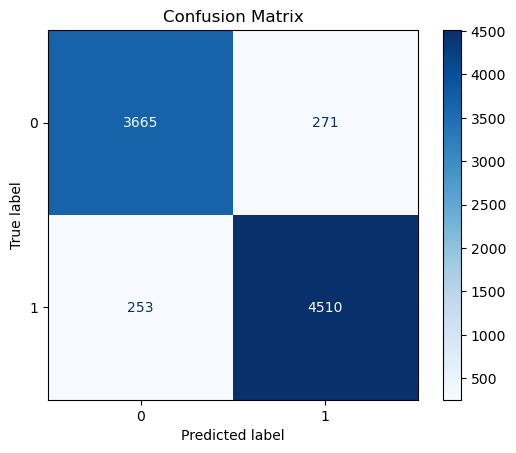

In [115]:
decis_model = train(embeddings, dataset["class"], method="Decision_Tree")

### MLP

Accuracy:
0.9962064605127026


Classification Report: MLP
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3894
           1       1.00      1.00      1.00      4805

    accuracy                           1.00      8699
   macro avg       1.00      1.00      1.00      8699
weighted avg       1.00      1.00      1.00      8699



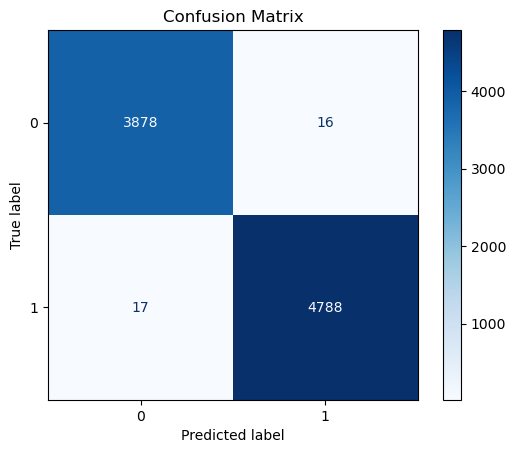

In [116]:
MLP_model = train(embeddings, dataset["class"], method="MLP")

### Evaluate on the testing set

In [117]:
embeddings2 = [doc2vec.infer_vector(row['text'].split()) for _, row in tqdm(testing_set.iterrows())]

3865it [00:07, 536.20it/s]


Accuracy:
0.9932729624838292


Classification Report: Logistic
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1753
           1       0.99      1.00      0.99      2112

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865



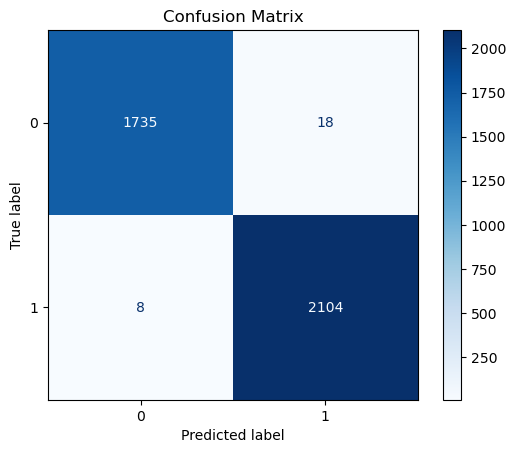

Metric  Count
0   True Positives (TP)   2104
1   True Negatives (TN)   1735
2  False Positives (FP)     18
3  False Negatives (FN)      8

In [118]:
printMetrics(testing_set["class"], logis_model.predict(embeddings2), method= "Logistic")

Accuracy:
0.9407503234152652


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1753
           1       0.95      0.94      0.95      2112

    accuracy                           0.94      3865
   macro avg       0.94      0.94      0.94      3865
weighted avg       0.94      0.94      0.94      3865



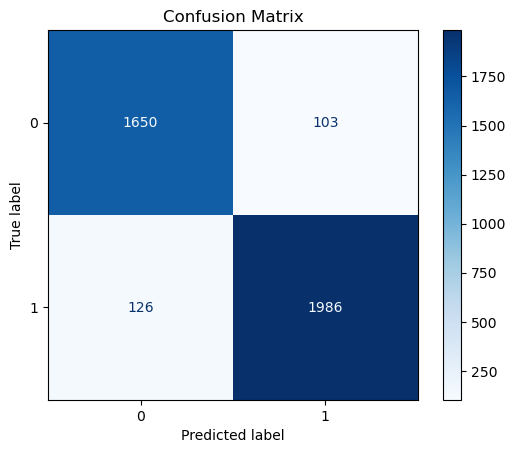

Metric  Count
0   True Positives (TP)   1986
1   True Negatives (TN)   1650
2  False Positives (FP)    103
3  False Negatives (FN)    126

In [119]:
printMetrics(testing_set["class"], decis_model.predict(embeddings2), method= "Decision_Tree")

Accuracy:
0.9950840879689521


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1753
           1       1.00      0.99      1.00      2112

    accuracy                           1.00      3865
   macro avg       0.99      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



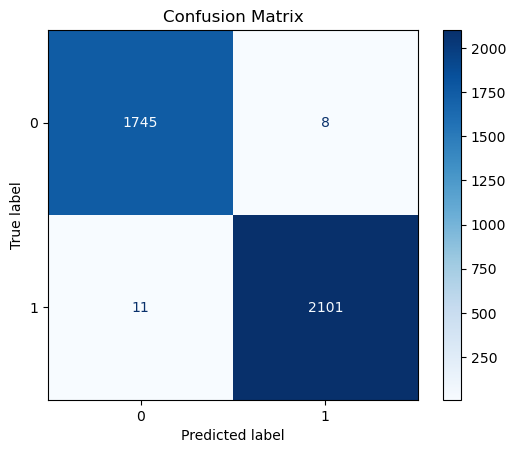

Metric  Count
0   True Positives (TP)   2101
1   True Negatives (TN)   1745
2  False Positives (FP)      8
3  False Negatives (FN)     11

In [120]:
printMetrics(testing_set["class"], MLP_model.predict(embeddings2), method= "MLP")

# Term Frequency Inverse Document Frequency (Tf-idf Vectorizer)

Tf-idf is another method similar to CBOW above that measures the importance of words to documents in a collection of corpus. In our use cases, we determine whether a word appear more frequently in our dataset of news, compute the weighting factor of words and convert the news training data into vectors. The results from the vectorizer can be used to feed as inputs to our classification models.

In [ ]:
def train_tfidf(x_train, x_test, y_train, y_test, method, max_iter=10000): # Minor adjustments to the method to fit the use case for Tf-idf
    if method == "Logistic":
        model = LogisticRegression(max_iter=max_iter)
    elif method == "Decision_Tree":
        model = DecisionTreeClassifier()
    elif method == "MLP":
        model = MLPClassifier(max_iter=max_iter)
    else:
        print(f"unknown method: {method}")
        return None

    try:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        printMetrics(y_test, y_pred, method)
        return model
    except Exception as e:
        print(f"An error occurred during model training: {e}")
        return None

In [ ]:
TfidfVec = TfidfVectorizer()
x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['class'], test_size=0.25)
# After spliting the dataset into training set and testing set, we vectorize the text inputs
x_train = TfidfVec.fit_transform(x_train)
x_test = TfidfVec.transform(x_test)

## Logistic regression

In [ ]:
tfidf_Log = train_tfidf(x_train, x_test, y_train, y_test, method = 'Logistic')

Accuracy:
0.983561328888378


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3944
           1       0.98      0.99      0.99      4755

    accuracy                           0.98      8699
   macro avg       0.98      0.98      0.98      8699
weighted avg       0.98      0.98      0.98      8699



## Decision Tree

In [ ]:
tfidf_Tree = train_tfidf(x_train, x_test, y_train, y_test, method = 'Decision_Tree')

Accuracy:
0.9939073456719163


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3944
           1       0.99      0.99      0.99      4755

    accuracy                           0.99      8699
   macro avg       0.99      0.99      0.99      8699
weighted avg       0.99      0.99      0.99      8699



## MLP Classifier

In [ ]:
tfidf_MLP = train_tfidf(x_train, x_test, y_train, y_test, method = 'MLP', max_iter = 200)

Accuracy:
0.9832164616622601


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3944
           1       0.98      0.99      0.98      4755

    accuracy                           0.98      8699
   macro avg       0.98      0.98      0.98      8699
weighted avg       0.98      0.98      0.98      8699



c:\Users\calla\anaconda3\envs\COMP4211\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Evaluate on the testing set

In [ ]:
printMetrics(testing_set["class"], tfidf_Log.predict(TfidfVec.transform(testing_set["text"])), method="Logistic")

Accuracy:
0.9816300129366106


Classification Report: Logistic
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1756
           1       0.98      0.99      0.98      2109

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865



Metric  Count
0   True Positives (TP)   2087
1   True Negatives (TN)   1707
2  False Positives (FP)     49
3  False Negatives (FN)     22

In [ ]:
printMetrics(testing_set["class"], tfidf_Tree.predict(TfidfVec.transform(testing_set["text"])), method="Decision_Tree")

Accuracy:
0.9943078913324709


Classification Report: Decision_Tree
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1756
           1       0.99      1.00      0.99      2109

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865



Metric  Count
0   True Positives (TP)   2100
1   True Negatives (TN)   1743
2  False Positives (FP)     13
3  False Negatives (FN)      9

In [ ]:
printMetrics(testing_set["class"], tfidf_MLP.predict(TfidfVec.transform(testing_set["text"])), method="MLP")

Accuracy:
0.9816300129366106


Classification Report: MLP
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1756
           1       0.98      0.99      0.98      2109

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865



Metric  Count
0   True Positives (TP)   2088
1   True Negatives (TN)   1706
2  False Positives (FP)     50
3  False Negatives (FN)     21

# Comparison Part
## Tuning pre-trained models (BERT and GPT) to apply onto classification models, and compare the results with our start-from-scratch word-embedding methods (Word2Vec, GloVe)


We want to utilise the pre-trained models and fine tune it to make it fit for our downstream tasks. To achieve so, we apply the tuned-model to a classification layer and feed the input to the classification models with our dataset.

Basically, we would obtain the text embedding results from the pre-trained model and we can use the outputs to feed into different classifier to classify whether a news is "Real" or "Fake".
Our classifiers contains:


*   Logistic Regression
*   Decision Tree
*   MLP

## 1) Fine-tuning BERT model and obtaining embedded results

In [11]:
from tqdm import tqdm
from torch.cuda.amp import autocast

In [ ]:
texts = dataset['text'].values
labels = dataset['class'].values

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and encode text
batch_size = 16
embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Getting BERT embeddings"):
    batch_texts = texts[i:i + batch_size]
    inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU if available
    for key in inputs:
        inputs[key] = inputs[key].to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling
        embeddings.append(batch_embeddings.cpu())  # Move back to CPU

# Concatenate all embeddings into a single tensor
embeddings = torch.cat(embeddings, dim=0)

# Convert embeddings to numpy array
embeddings_np = embeddings.numpy()

x_train, x_test, y_train, y_test = train_test_split(embeddings_np, labels, test_size=0.25)

Getting BERT embeddings: 100%|██████████| 2175/2175 [21:44<00:00,  1.67it/s]


After fine-tuning the model, now we would feed the inputs into the model and obtain the output accuracy.

### 1.1) Logistic Regression

In [14]:
def printMetrics(y, y_pred):
    print("Accuracy:")
    print(accuracy_score(y, y_pred))
    print("\n")

    print("Classification Report:")
    print(classification_report(y, y_pred))

    tn, fp, fn, tp = confusion_matrix(y, y_pred).flatten()
    results = {'Metric': ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)'], 'Count': [tp, tn, fp, fn]}
    results = pd.DataFrame(results)
    return results

In [ ]:
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(x_train, y_train)
y_pred_logistic = logistic_model.predict(x_test)

# Print out the accuracy and other related metrics
printMetrics(y_test, y_pred_logistic)

Accuracy:
0.9925278767674446


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4002
           1       0.99      1.00      0.99      4697

    accuracy                           0.99      8699
   macro avg       0.99      0.99      0.99      8699
weighted avg       0.99      0.99      0.99      8699



Metric  Count
0   True Positives (TP)   4675
1   True Negatives (TN)   3959
2  False Positives (FP)     43
3  False Negatives (FN)     22

### 1.2) Decision Tree

In [ ]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train, y_train)
y_pred_tree = decision_tree_model.predict(x_test)

# Print out the accuracy and other related metrics
printMetrics(y_test, y_pred_tree)

Accuracy:
0.9178066444418899


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4002
           1       0.92      0.93      0.92      4697

    accuracy                           0.92      8699
   macro avg       0.92      0.92      0.92      8699
weighted avg       0.92      0.92      0.92      8699



Metric  Count
0   True Positives (TP)   4351
1   True Negatives (TN)   3633
2  False Positives (FP)    369
3  False Negatives (FN)    346

### 1.3) MLP

In [ ]:
mlp_model = MLPClassifier(max_iter=1000)
mlp_model.fit(x_train, y_train)
y_pred_mlp = mlp_model.predict(x_test)

# Print out the accuracy and other related metrics
printMetrics(y_test, y_pred_mlp)

Accuracy:
0.9942522128980342


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4002
           1       0.99      0.99      0.99      4697

    accuracy                           0.99      8699
   macro avg       0.99      0.99      0.99      8699
weighted avg       0.99      0.99      0.99      8699



Metric  Count
0   True Positives (TP)   4672
1   True Negatives (TN)   3977
2  False Positives (FP)     25
3  False Negatives (FN)     25

We then can also plot the ROC curve similar to the one in PA1.

In [ ]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC curve (area = {roc_auc:.2f})')
    return roc_auc

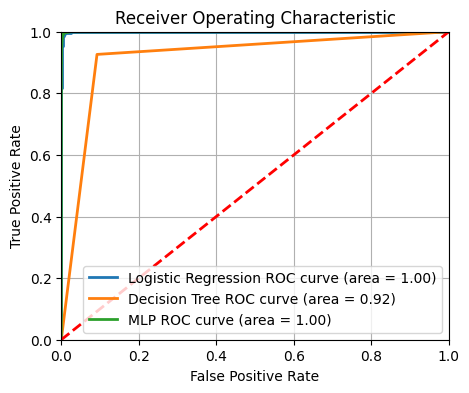

Logistic Regression ROC AUC: 0.9994725332671115
Decision Tree ROC AUC: 0.9170660305359349
MLP ROC AUC: 0.9997952641733211


In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba_logistic = logistic_model.predict_proba(x_test)[:, 1]
y_pred_proba_tree = decision_tree_model.predict_proba(x_test)[:, 1]
y_pred_proba_mlp = mlp_model.predict_proba(x_test)[:, 1]

# Plot ROC curves
plt.figure(figsize=(5, 4))

# Plot for each model
roc_auc_logistic = plot_roc_curve(y_test, y_pred_proba_logistic, 'Logistic Regression')
roc_auc_tree = plot_roc_curve(y_test, y_pred_proba_tree, 'Decision Tree')
roc_auc_mlp = plot_roc_curve(y_test, y_pred_proba_mlp, 'MLP')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC scores
print("Logistic Regression ROC AUC:", roc_auc_logistic)
print("Decision Tree ROC AUC:", roc_auc_tree)
print("MLP ROC AUC:", roc_auc_mlp)

In [ ]:
test_texts  = testing_set["text"].values
test_labels = testing_set["class"].values

# Load GPT-2 tokenizer and model
tokenizer_test = BertTokenizer.from_pretrained('bert-base-uncased')
model_test = BertModel.from_pretrained('bert-base-uncased')

# Move model to GPU if available
device_test = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device_test)

# Tokenize and encode text
batch_size = 16
embeddings_test = []

for i in tqdm(range(0, len(test_texts), batch_size), desc="Getting BERT embeddings"):
    batch_texts = test_texts[i:i + batch_size]
    inputs = tokenizer_test(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU if available
    for key in inputs:
        inputs[key] = inputs[key].to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling
        embeddings_test.append(batch_embeddings.cpu())  # Move back to CPU

# Concatenate all embeddings into a single tensor
embeddings_test = torch.cat(embeddings_test, dim=0)

# Convert embeddings to numpy array
embeddings_test_np = embeddings_test.numpy()

Getting BERT embeddings: 100%|██████████| 242/242 [02:25<00:00,  1.67it/s]


In [ ]:
# Print out the accuracy and other related metrics
printMetrics(test_labels, logistic_model.predict(embeddings_test_np))

Accuracy:
0.9919793014230271


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1762
           1       0.99      0.99      0.99      2103

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865



Metric  Count
0   True Positives (TP)   2087
1   True Negatives (TN)   1747
2  False Positives (FP)     15
3  False Negatives (FN)     16

In [ ]:
# Print out the accuracy and other related metrics
printMetrics(test_labels, decision_tree_model.predict(embeddings_test_np))

Accuracy:
0.920051746442432


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1762
           1       0.93      0.92      0.93      2103

    accuracy                           0.92      3865
   macro avg       0.92      0.92      0.92      3865
weighted avg       0.92      0.92      0.92      3865



Metric  Count
0   True Positives (TP)   1942
1   True Negatives (TN)   1614
2  False Positives (FP)    148
3  False Negatives (FN)    161

In [ ]:
# Print out the accuracy and other related metrics
printMetrics(test_labels, mlp_model.predict(embeddings_test_np))

Accuracy:
0.9958602846054334


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1762
           1       1.00      0.99      1.00      2103

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



Metric  Count
0   True Positives (TP)   2090
1   True Negatives (TN)   1759
2  False Positives (FP)      3
3  False Negatives (FN)     13

## 2) Fine tuning GPT model and obtaining embedded results

In [ ]:
texts = dataset['text'].values
labels = dataset['class'].values

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

# Set the padding token to the EOS token
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as padding

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize and encode text
batch_size = 16
embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Getting GPT embeddings"):
    batch_texts = texts[i:i + batch_size]
    inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU if available
    for key in inputs:
        inputs[key] = inputs[key].to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling
        embeddings.append(batch_embeddings.cpu())  # Move back to CPU

# Concatenate all embeddings into a single tensor
embeddings = torch.cat(embeddings, dim=0)

# Convert embeddings to numpy array
embeddings_np = embeddings.numpy()

# Split the dataset
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(embeddings_np, labels, test_size=0.25)

Getting GPT embeddings: 100%|██████████| 2175/2175 [19:11<00:00,  1.89it/s]


### 2.1) Logistic Regression

In [ ]:
logistic_model_2 = LogisticRegression(max_iter=10000)
logistic_model_2.fit(x_train_2, y_train_2)
y_pred_logistic_2 = logistic_model_2.predict(x_test_2)

# Print out the accuracy and other related metrics
printMetrics(y_test_2, y_pred_logistic_2)

Accuracy:
0.9995401770318427


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3895
           1       1.00      1.00      1.00      4804

    accuracy                           1.00      8699
   macro avg       1.00      1.00      1.00      8699
weighted avg       1.00      1.00      1.00      8699



Metric  Count
0   True Positives (TP)   4801
1   True Negatives (TN)   3894
2  False Positives (FP)      1
3  False Negatives (FN)      3

### 2.2) Decision Tree

In [ ]:
decision_tree_model_2 = DecisionTreeClassifier()
decision_tree_model_2.fit(x_train_2, y_train_2)
y_pred_tree_2 = decision_tree_model_2.predict(x_test_2)

# Print out the accuracy and other related metrics
printMetrics(y_test_2, y_pred_tree_2)

Accuracy:
0.9687320381653064


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3895
           1       0.97      0.97      0.97      4804

    accuracy                           0.97      8699
   macro avg       0.97      0.97      0.97      8699
weighted avg       0.97      0.97      0.97      8699



Metric  Count
0   True Positives (TP)   4662
1   True Negatives (TN)   3765
2  False Positives (FP)    130
3  False Negatives (FN)    142

### 2.3) MLP

In [ ]:
mlp_model_2 = MLPClassifier(max_iter=1000)
mlp_model_2.fit(x_train_2, y_train_2)
y_pred_mlp_2 = mlp_model_2.predict(x_test_2)

# Print out the accuracy and other related metrics
printMetrics(y_test_2, y_pred_mlp_2)

Accuracy:
0.9995401770318427


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3895
           1       1.00      1.00      1.00      4804

    accuracy                           1.00      8699
   macro avg       1.00      1.00      1.00      8699
weighted avg       1.00      1.00      1.00      8699



Metric  Count
0   True Positives (TP)   4801
1   True Negatives (TN)   3894
2  False Positives (FP)      1
3  False Negatives (FN)      3

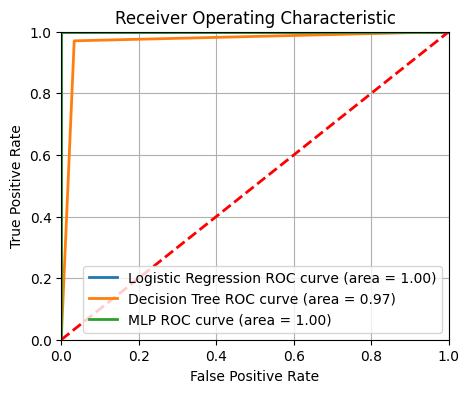

Logistic Regression ROC AUC: 0.9999991983573808
Decision Tree ROC AUC: 0.968532587841326
MLP ROC AUC: 0.9999995724572697


In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba_logistic_2 = logistic_model_2.predict_proba(x_test_2)[:, 1]
y_pred_proba_tree_2 = decision_tree_model_2.predict_proba(x_test_2)[:, 1]
y_pred_proba_mlp_2 = mlp_model_2.predict_proba(x_test_2)[:, 1]

# Plot ROC curves
plt.figure(figsize=(5, 4))

# Plot for each model
roc_auc_logistic_2 = plot_roc_curve(y_test_2, y_pred_proba_logistic_2, 'Logistic Regression')
roc_auc_tree_2 = plot_roc_curve(y_test_2, y_pred_proba_tree_2, 'Decision Tree')
roc_auc_mlp_2 = plot_roc_curve(y_test_2, y_pred_proba_mlp_2, 'MLP')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC scores
print("Logistic Regression ROC AUC:", roc_auc_logistic_2)
print("Decision Tree ROC AUC:", roc_auc_tree_2)
print("MLP ROC AUC:", roc_auc_mlp_2)

In [ ]:
test_texts  = testing_set["text"].values
test_labels = testing_set["class"].values

# Load GPT-2 tokenizer and model
tokenizer_test = GPT2Tokenizer.from_pretrained('gpt2')
model_test = GPT2Model.from_pretrained('gpt2')

# Set the padding token to the EOS token
tokenizer_test.pad_token = tokenizer_test.eos_token  # Use EOS token as padding

# Move model to GPU if available
device_test = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device_test)

# Tokenize and encode text
batch_size = 16
embeddings_test = []

for i in tqdm(range(0, len(test_texts), batch_size), desc="Getting GPT embeddings"):
    batch_texts = test_texts[i:i + batch_size]
    inputs = tokenizer_test(batch_texts.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU if available
    for key in inputs:
        inputs[key] = inputs[key].to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling
        embeddings_test.append(batch_embeddings.cpu())  # Move back to CPU

# Concatenate all embeddings into a single tensor
embeddings_test = torch.cat(embeddings_test, dim=0)

# Convert embeddings to numpy array
embeddings_test_np = embeddings_test.numpy()

Getting GPT embeddings: 100%|██████████| 242/242 [02:10<00:00,  1.86it/s]


In [ ]:
# Print out the accuracy and other related metrics
printMetrics(test_labels, logistic_model_2.predict(embeddings_test_np))

Accuracy:
0.9994825355756791


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1762
           1       1.00      1.00      1.00      2103

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



Metric  Count
0   True Positives (TP)   2101
1   True Negatives (TN)   1762
2  False Positives (FP)      0
3  False Negatives (FN)      2

In [ ]:
# Print out the accuracy and other related metrics
printMetrics(test_labels, decision_tree_model_2.predict(embeddings_test_np))

Accuracy:
0.9588615782664942


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1762
           1       0.97      0.96      0.96      2103

    accuracy                           0.96      3865
   macro avg       0.96      0.96      0.96      3865
weighted avg       0.96      0.96      0.96      3865



Metric  Count
0   True Positives (TP)   2016
1   True Negatives (TN)   1690
2  False Positives (FP)     72
3  False Negatives (FN)     87

In [ ]:
# Print out the accuracy and other related metrics
printMetrics(test_labels, mlp_model_2.predict(embeddings_test_np))

Accuracy:
0.9997412677878396


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1762
           1       1.00      1.00      1.00      2103

    accuracy                           1.00      3865
   macro avg       1.00      1.00      1.00      3865
weighted avg       1.00      1.00      1.00      3865



Metric  Count
0   True Positives (TP)   2102
1   True Negatives (TN)   1762
2  False Positives (FP)      0
3  False Negatives (FN)      1

### Experiment: Potential improvement for the decision tree model?

In [12]:
x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['class'], test_size=0.25)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts, desc="Getting BERT embeddings"):
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)

# Get BERT embeddings for training and testing sets
x_train_embeddings = get_bert_embeddings(x_train)
x_test_embeddings = get_bert_embeddings(x_test)

Getting BERT embeddings: 100%|██████████| 8699/8699 [04:33<00:00, 31.84it/s]


In [33]:
# 1. Dimensionality Reduction with PCA
pca = PCA(n_components=25)
x_train_pca = pca.fit_transform(x_train_embeddings)
x_test_pca = pca.transform(x_test_embeddings)

decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train_pca, y_train)
y_pred_pca_tree = decision_tree_model.predict(x_test_pca)
printMetrics(y_test, y_pred_pca_tree)

Accuracy:
0.9457408897574434


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3916
           1       0.95      0.95      0.95      4783

    accuracy                           0.95      8699
   macro avg       0.95      0.95      0.95      8699
weighted avg       0.95      0.95      0.95      8699



Metric  Count
0   True Positives (TP)   4555
1   True Negatives (TN)   3672
2  False Positives (FP)    244
3  False Negatives (FN)    228

In [34]:
# 2. Try to use random forest instead of decision tree
rf_model = RandomForestClassifier()
rf_model.fit(x_train_pca, y_train)
y_pred_rf = rf_model.predict(x_test_pca)
printMetrics(y_test, y_pred_rf)

Accuracy:
0.9660880560984021


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3916
           1       0.96      0.98      0.97      4783

    accuracy                           0.97      8699
   macro avg       0.97      0.96      0.97      8699
weighted avg       0.97      0.97      0.97      8699



Metric  Count
0   True Positives (TP)   4681
1   True Negatives (TN)   3723
2  False Positives (FP)    193
3  False Negatives (FN)    102